# ING Lion's Den 2024

## Team: RiskBusters


 Michał Bryzik, Michał Niegierewicz, Kacper Gruca, Jan Ślusarek
 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score,average_precision_score, recall_score, f1_score,precision_recall_curve, auc, classification_report, confusion_matrix, make_scorer, fbeta_score
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.utils import resample
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve
from scipy import stats
import statsmodels.tools as sm_tools
import statsmodels.stats.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.genmod.generalized_linear_model import GLM
from statsmodels.genmod.families import Binomial
from statsmodels.genmod.families.links import logit
from statsmodels.tools import add_constant
from imblearn.over_sampling import SMOTE, RandomOverSampler, ADASYN
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import BaggingClassifier



In [19]:
df_train=pd.read_csv('../data/output/categorical_dfs/development_sample_woe.csv')
df_test=pd.read_csv('../data/output/categorical_dfs/testing_sample_woe_after_right_filling.csv')

In [20]:
mean_Var4_woe = df_test['Var4_woe'].mean()

# Replace NaN values in 'Var4_woe' with its mean
df_test['Var4_woe'].fillna(mean_Var4_woe, inplace=True)

# Creating basic model for WOE data



Since we experimented with various data sets, we discovered that data transformed using Weight of Evidence (WOE) proved to be the most effective for our logistic regression model. Logistic regression has fewer assumptions compared to linear regression, the main ones being:

1. There is no collinearity between the variables.
2. The logit (the logarithm of the odds) of the probability is a linear function of the independent variables

Optimization terminated successfully.
         Current function value: 0.116173
         Iterations 9


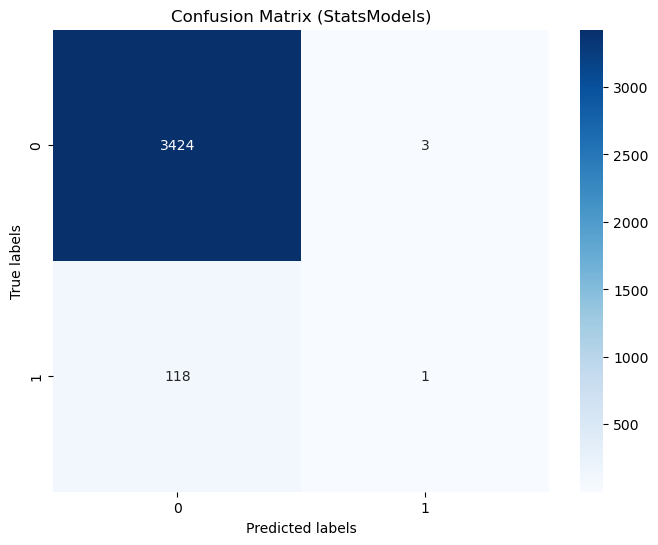

In [21]:
import statsmodels.api as sm

# Using statmodels library due to simple descriptive analysis
X_train = df_train.drop('target', axis=1)
y_train = df_train['target']
X_test = df_test.drop('target', axis=1)
y_test = df_test['target']

X_train_sm = sm.add_constant(X_train)  
y_train_sm = y_train


model_sm = sm.Logit(y_train_sm, X_train_sm).fit()


X_test_sm = sm.add_constant(X_test)  
y_pred_prob_sm = model_sm.predict(X_test_sm)


y_pred_sm = (y_pred_prob_sm >= 0.5).astype(int)


conf_matrix_sm = confusion_matrix(y_test, y_pred_sm)


plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_sm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix (StatsModels)')
plt.show()


Basic logit model has weak forecasting features, as we could see in the confusion matrix above. In the next stage we will want to manipulate the parameters of this model to improve accuracy of the prediction. 

In [22]:

model_summary = model_sm.summary()
model_summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 target   No. Observations:                35700
Model:                          Logit   Df Residuals:                    35681
Method:                           MLE   Df Model:                           18
Date:                Thu, 14 Mar 2024   Pseudo R-squ.:                  0.1560
Time:                        21:54:30   Log-Likelihood:                -4147.4
converged:                       True   LL-Null:                       -4914.1
Covariance Type:            nonrobust   LLR p-value:                     0.000
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   12.6964      0.565     22.458      0.000      11.588      13.804
Var11_woe               -1.2523      0.101    -12.363      0.000      -1.451      -1.054
Var12_woe               -1.5831      0.196     -8.086      0.000      -1.967      -1.199
Var14_woe               -1.0506      0.130     -8.070      0.000      -1.306      -0.795
Var17_1_woe             -2.3608      0.192    -12.288      0.000      -2.737      -1.984
Var25_q_woe             -1.1387      0.140     -8.116      0.000      -1.414      -0.864
Var26_q_woe             -0.7430      0.105     -7.052      0.000      -0.949      -0.536
Var27_woe               -0.3479      0.182     -1.907      0.056      -0.705       0.010
Var28_woe               -1.6745      0.104    -16.148      0.000      -1.878      -1.471
Var29_woe               -1.2566      0.128     -9.851      0.000      -1.507      -1.007
Var3_woe                 0.0354      0.275      0.129      0.898      -0.504       0.575
Var4_woe                 0.2573      0.241      1.066      0.286      -0.216       0.730
Var5_woe                -0.6376      0.270     -2.361      0.018      -1.167      -0.108
Var8_q_woe              -0.5178      0.180     -2.884      0.004      -0.870      -0.166
idi_ratio_woe           -0.7453      0.098     -7.575      0.000      -0.938      -0.552
ii_ratio_woe            -0.3597      0.156     -2.302      0.021      -0.666      -0.053
income_woe              -0.9192      0.139     -6.630      0.000      -1.191      -0.647
loan_desc_woe           -0.7981      0.116     -6.910      0.000      -1.024      -0.572
working_months_1_woe    -0.2858      0.140     -2.038      0.042      -0.561      -0.011
========================================================================================
"""

The logistic regression model was fitted to the data using Maximum Likelihood Estimation (MLE), aiming to model the relationship between the binary outcome variable "target" and a set of predictor variables. The dataset consists of 35,700 observations, enabling robust statistical inference.

The pseudo R-squared of 0.1560 suggests that approximately 15.6% of the variance in the outcome variable is explained by the predictor variables. The log-likelihood value of -4147.4 indicates a significant improvement over the null model (LL-Null: -4914.1), supported by an associated LLR p-value of 0.000. These results signify the superiority of the applied model in explaining the outcome compared to a model with no predictor variables.

Analyzing the coefficients provides insights into the impact of individual predictor variables on the outcome variable. The intercept, or the intercept, is estimated at 12.6964, representing the baseline log-odds when all predictor variables are equal to zero. Statistically significant effects are observed for variables such as Var11_woe, Var12_woe, Var14_woe, Var17_1_woe, etc., with coefficients having p-values < 0.05. Variable Var28_woe stands out with a particularly strong negative association with the outcome variable, evidenced by a coefficient of -1.6745.

Each coefficient represents the change in the log-odds of the outcome variable associated with a one-unit change in the corresponding predictor variable, assuming all other variables remain constant. For example, a one-unit increase in Var11_woe corresponds to a decrease of 1.2523 in the log-odds of the outcome variable, holding all other variables constant.

In conclusion, the logistic regression model provides valuable insights into the relationships between predictor variables and the likelihood of the outcome variable. Despite demonstrating satisfactory fit and statistical significance of coefficients, further validation and exploration of model assumptions and predictive performance may be necessary to ensure its reliability and generalizability in practice.

In [23]:
# Computing necessary metrics 

y_pred_train_sm = (model_sm.predict(X_train_sm) >= 0.5).astype(int)


accuracy_train = accuracy_score(y_train_sm, y_pred_train_sm)
precision_train = precision_score(y_train_sm, y_pred_train_sm)
recall_train = recall_score(y_train_sm, y_pred_train_sm)
f1_train = f1_score(y_train_sm, y_pred_train_sm)

accuracy_test = accuracy_score(y_test, y_pred_sm)
precision_test = precision_score(y_test, y_pred_sm)
recall_test = recall_score(y_test, y_pred_sm)
f1_test = f1_score(y_test, y_pred_sm)

(accuracy_train, precision_train, recall_train, f1_train, accuracy_test, precision_test, recall_test, f1_test)

(0.9699159663865546,
 0.6708860759493671,
 0.048138056312443236,
 0.08983050847457627,
 0.9658770445572477,
 0.25,
 0.008403361344537815,
 0.016260162601626015)

Accuracy: High accuracy on the training set (0.9699) and the test set (0.9659) suggests that the model correctly classifies the majority of cases. However, it's worth noting that accuracy alone may not be sufficient to evaluate the model, especially when classes in the dataset are imbalanced.

Precision: Precision on the training set (0.6709) and the test set (0.25) measures how many of the positive predictions made by the model are actually correct. High precision indicates that the model rarely makes False Positive errors.

Recall: Low recall on the training set (0.0481) and the test set (0.0084) suggests that the model struggles to identify true positive cases. This means that many positive cases are being missed by the model.

F1 Score: Low F1 score on the training set (0.0898) and the test set (0.0163) indicates an unbalanced performance of the model, with a low balance between precision and recall.


Below we apllied VIF analysis to detect colinearity of variables

In [24]:
# Creating VIF metrics based on training dataset
VIF_data = pd.DataFrame()
VIF_data["variable"] = X_train.columns
VIF_data["VIF"] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
print(VIF_data)


                variable         VIF
0              Var11_woe    9.452256
1              Var12_woe   48.074500
2              Var14_woe   18.570537
3            Var17_1_woe   31.624024
4            Var25_q_woe   16.839189
5            Var26_q_woe    5.575662
6              Var27_woe  124.086942
7              Var28_woe   44.664399
8              Var29_woe   28.330658
9               Var3_woe   89.612623
10              Var4_woe   66.119336
11              Var5_woe   77.518278
12            Var8_q_woe   23.205567
13         idi_ratio_woe   16.949063
14          ii_ratio_woe   28.755720
15            income_woe   17.280532
16         loan_desc_woe   15.164641
17  working_months_1_woe   24.588123





VIF = 1: No correlation between the variable and other variables.
1 < VIF < 5: Moderate correlation, usually not a problem.
VIF >= 5: High correlation, worth investigating as it may indicate an issue with multicollinearity.
VIF >= 10: Indicates very high correlation and serious problems with multicollinearity, which can distort regression analysis.

Var11_woe: VIF = 9.452256 - Indicates a moderate level of correlation with other variables.

Var12_woe: VIF = 48.074500 - Indicates a high level of correlation, potentially indicating multicollinearity issues.

Var14_woe: VIF = 18.570537 - Indicates a moderate level of correlation with other variables.

Var17_1_woe: VIF = 31.624024 - Indicates a high level of correlation, potentially indicating multicollinearity issues.

Var25_q_woe: VIF = 16.839189 - Indicates a moderate level of correlation with other variables.

Var26_q_woe: VIF = 5.575662 - Indicates a moderate level of correlation with other variables.

Var27_woe: VIF = 124.086942 - Indicates a very high level of correlation and serious problems with multicollinearity.

Var28_woe: VIF = 44.664399 - Indicates a high level of correlation, potentially indicating multicollinearity issues.

Var29_woe: VIF = 28.330658 - Indicates a high level of correlation, potentially indicating multicollinearity issues.

Var3_woe: VIF = 89.612623 - Indicates a very high level of correlation and serious problems with multicollinearity.

Var4_woe: VIF = 66.119336 - Indicates a very high level of correlation and serious problems with multicollinearity.

Var5_woe: VIF = 77.518278 - Indicates a very high level of correlation and serious problems with multicollinearity.

Var8_q_woe: VIF = 23.205567 - Indicates a high level of correlation, potentially indicating multicollinearity issues.

idi_ratio_woe: VIF = 16.949063 - Indicates a moderate level of correlation with other variables.

ii_ratio_woe: VIF = 28.755720 - Indicates a high level of correlation, potentially indicating multicollinearity issues.

income_woe: VIF = 17.280532 - Indicates a moderate level of correlation with other variables.

loan_desc_woe: VIF = 15.164641 - Indicates a moderate level of correlation with other variables.

working_months_1_woe: VIF = 24.588123 - Indicates a high level of correlation, potentially indicating multicollinearity issues.

# Modify threshold parameter for logit model

According to score modelling of risk theory, we could manipulate threshold to improve accuracy od our models. 

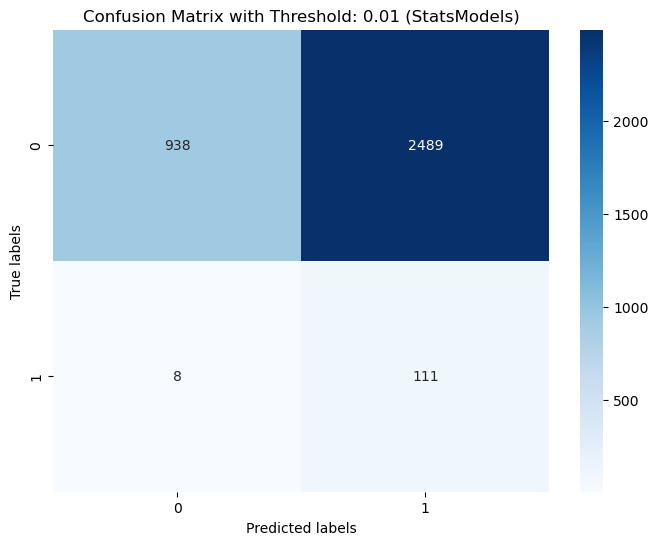

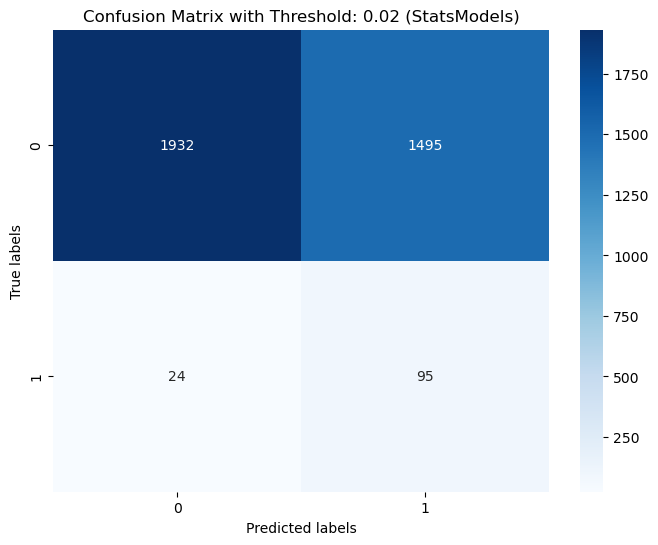

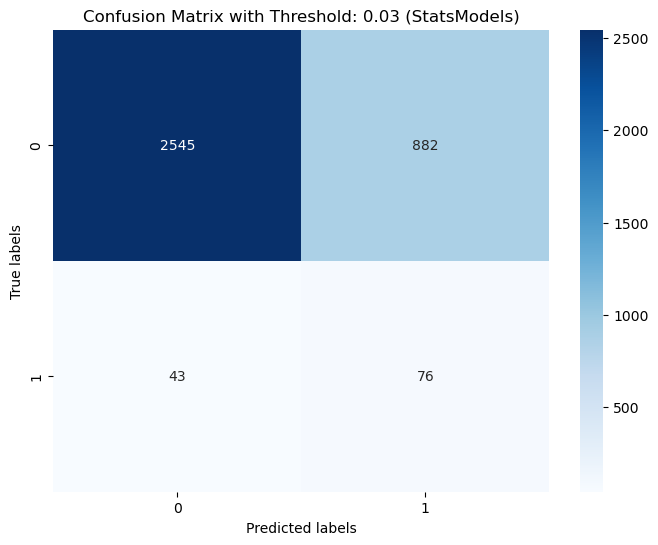

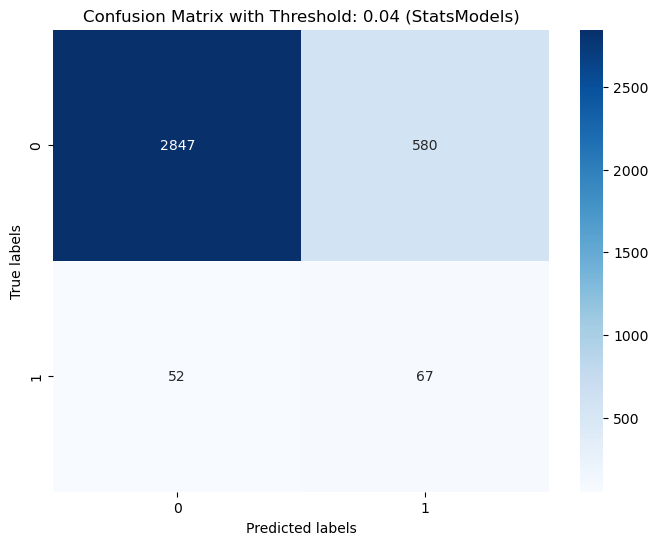

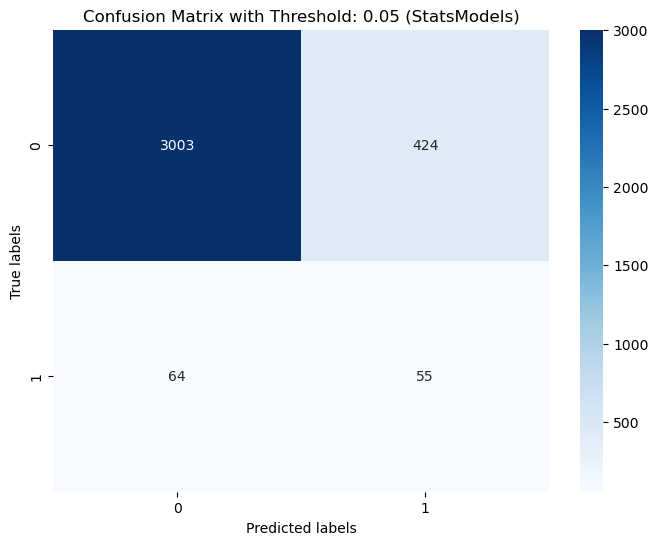

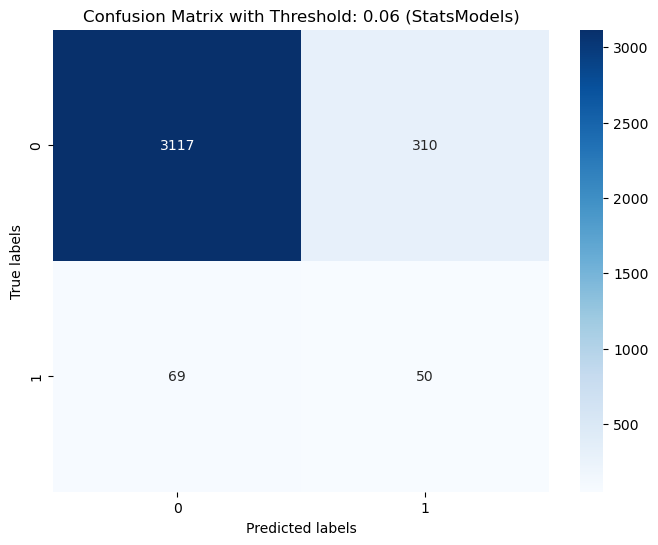

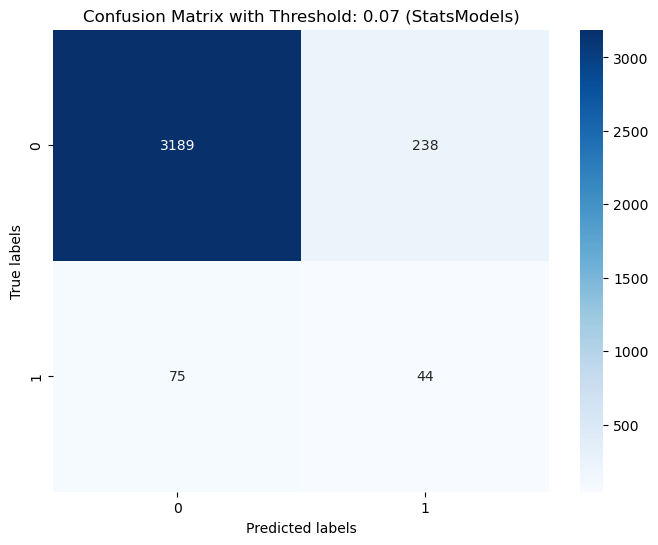

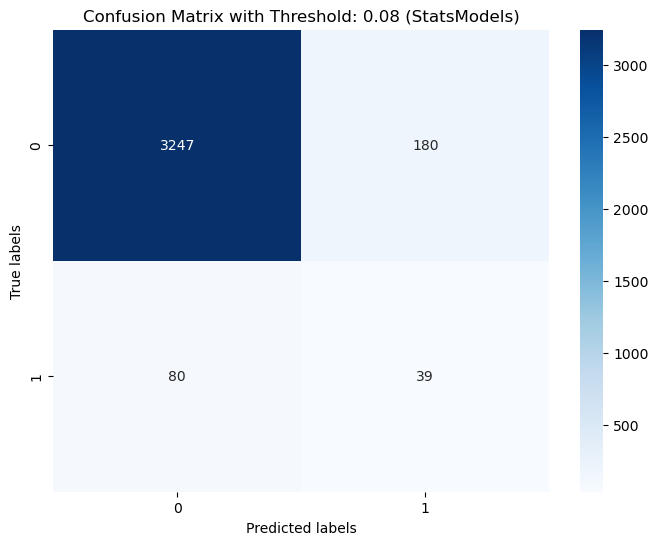

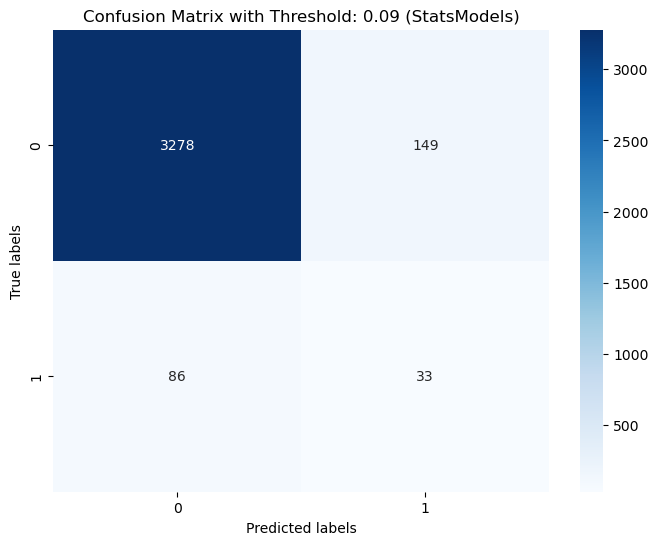

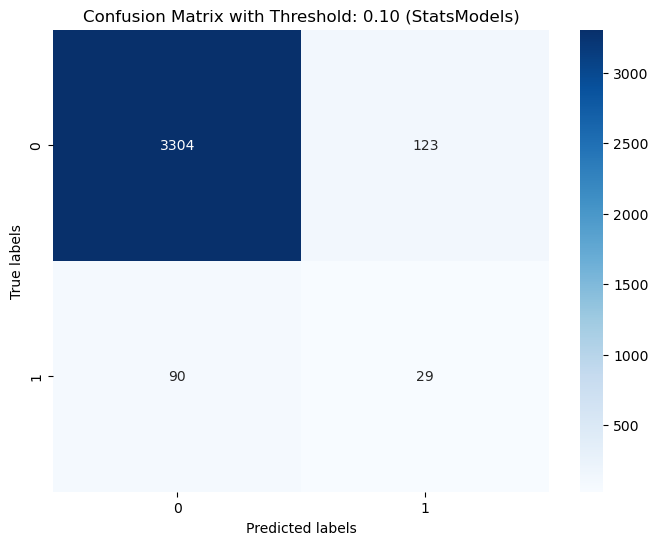

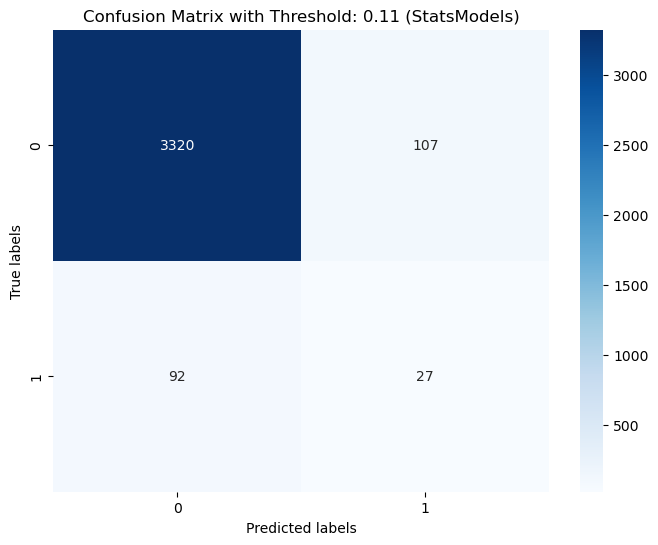

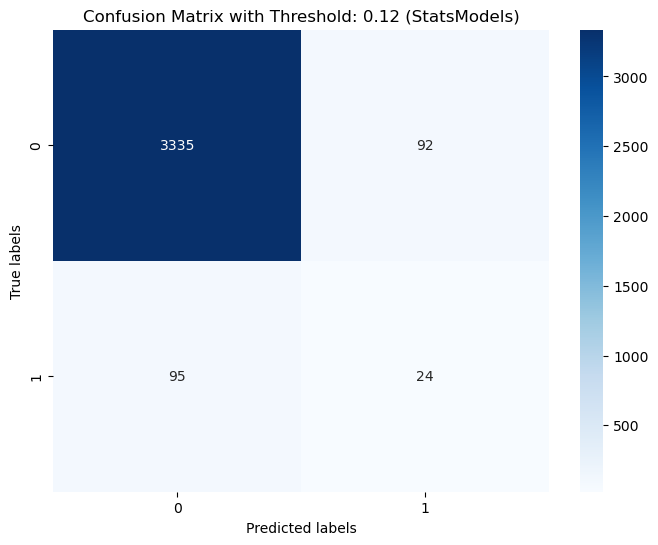

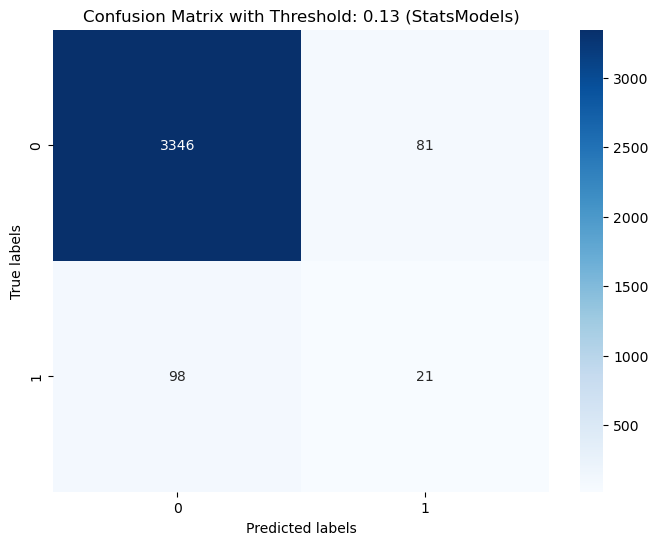

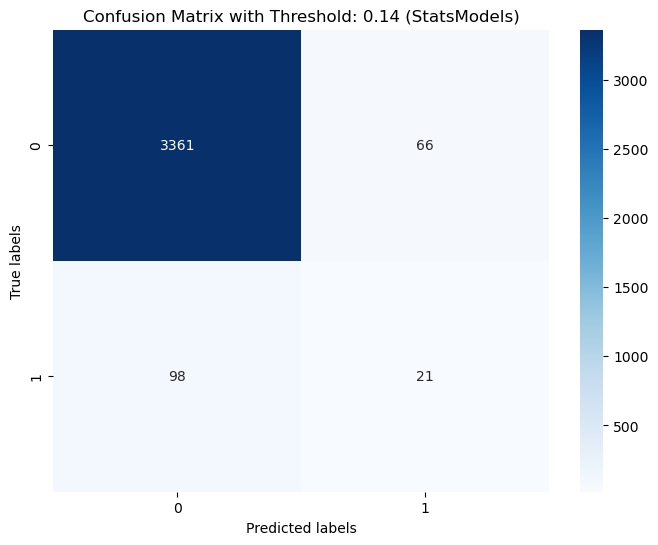

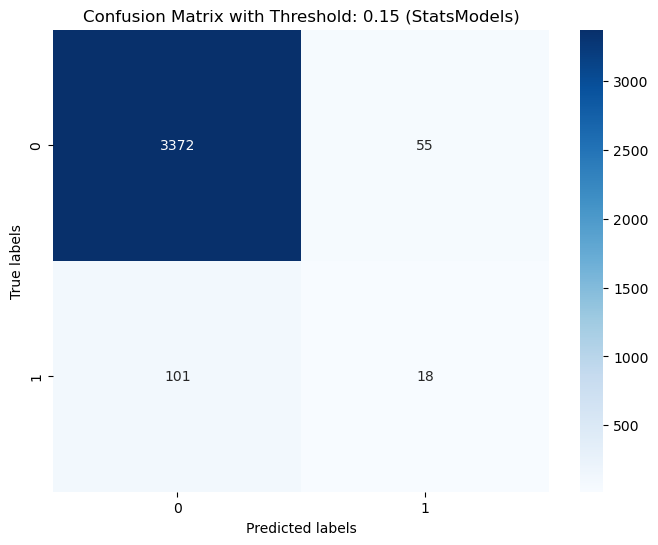

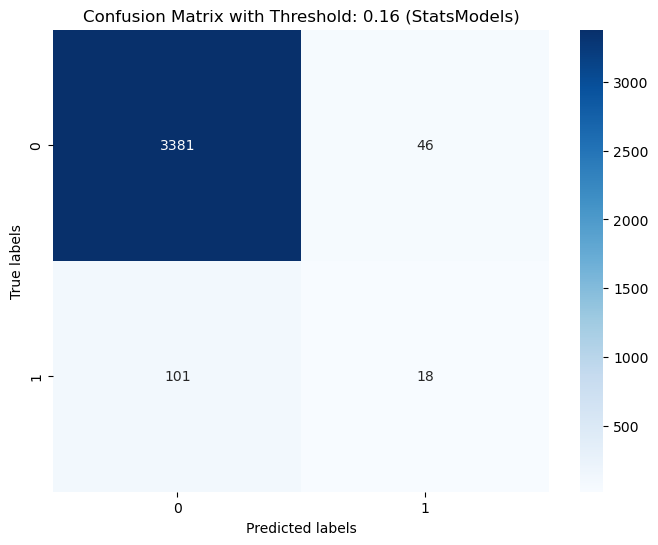

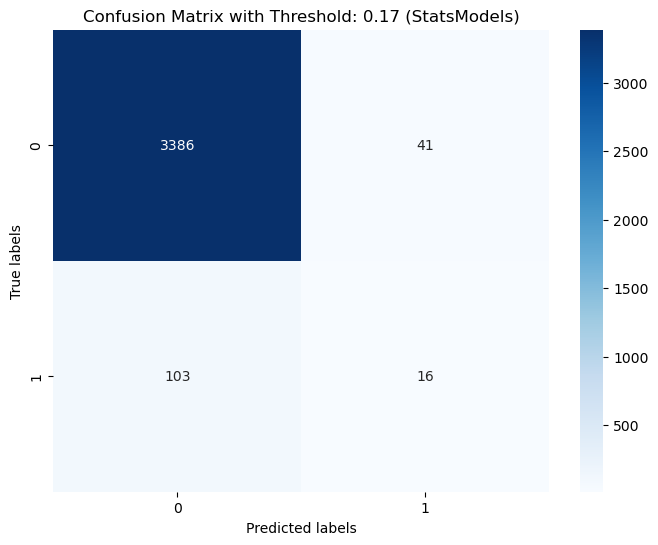

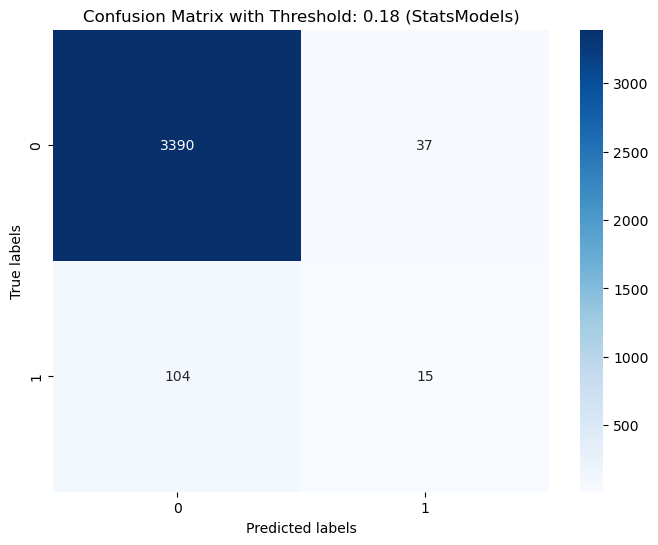

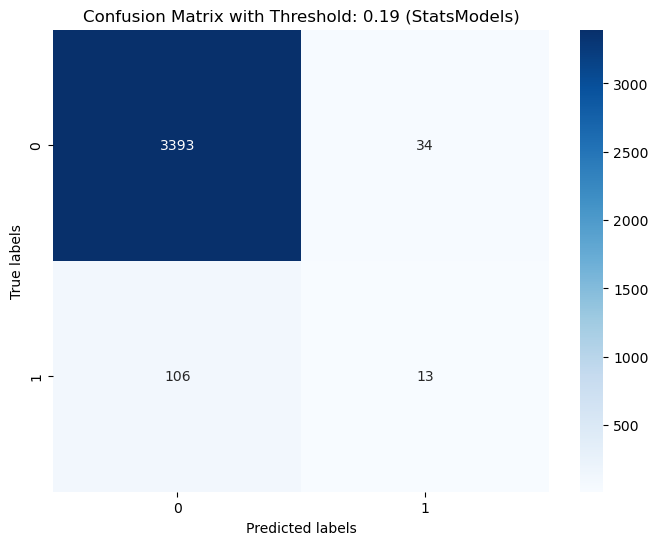

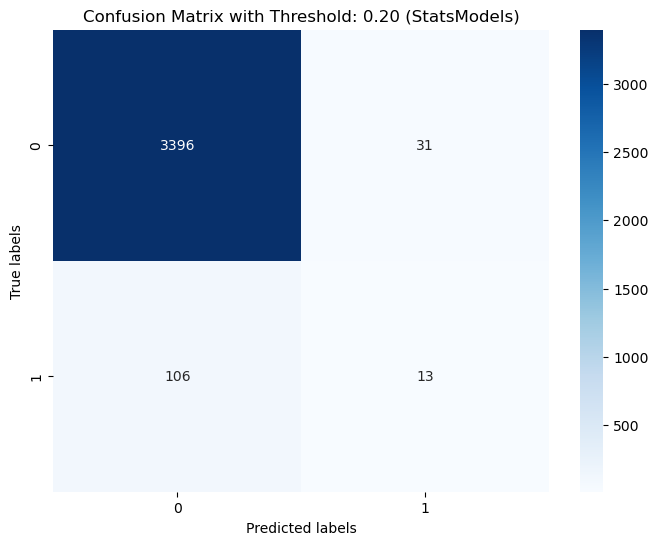

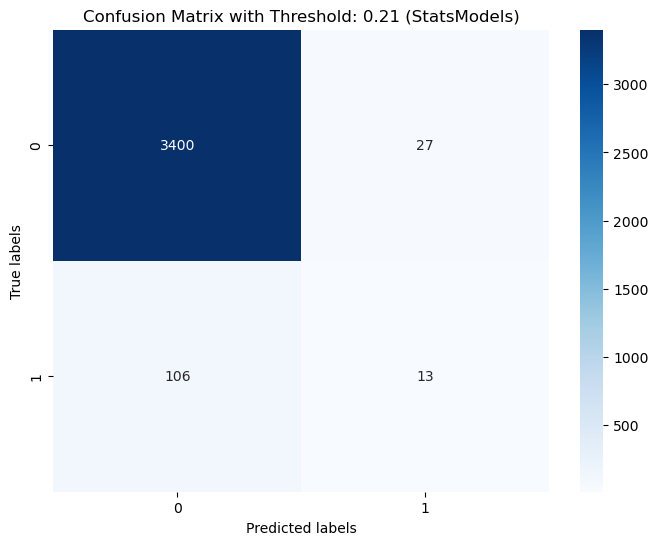

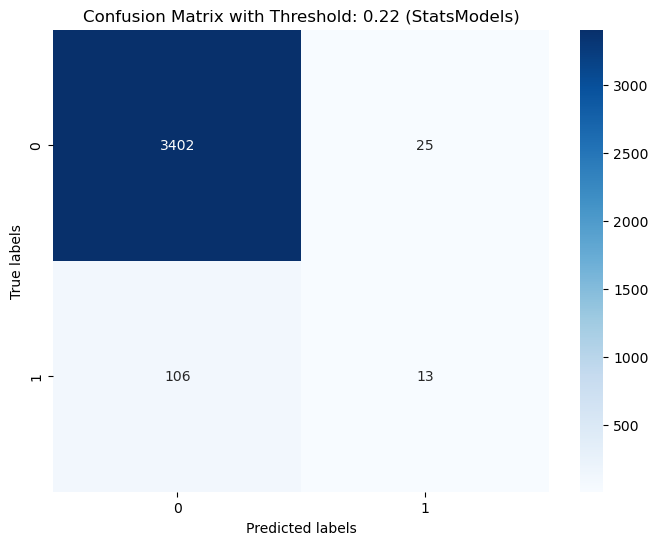

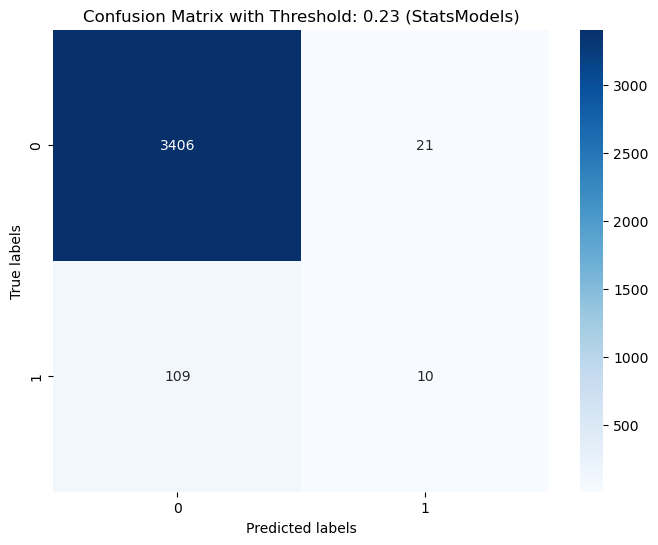

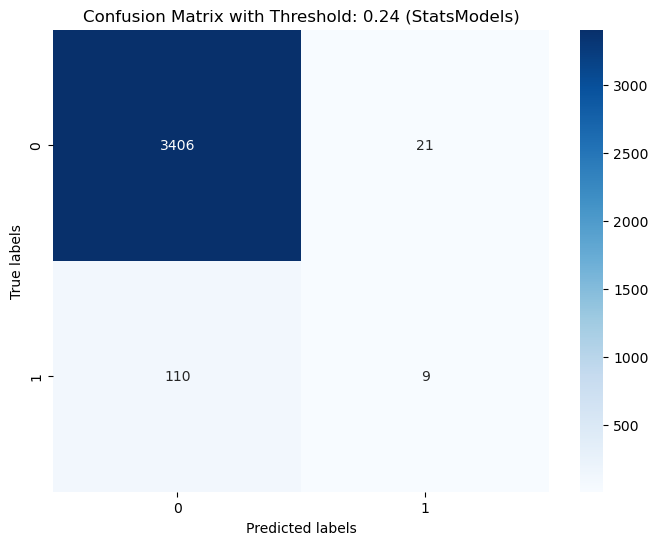

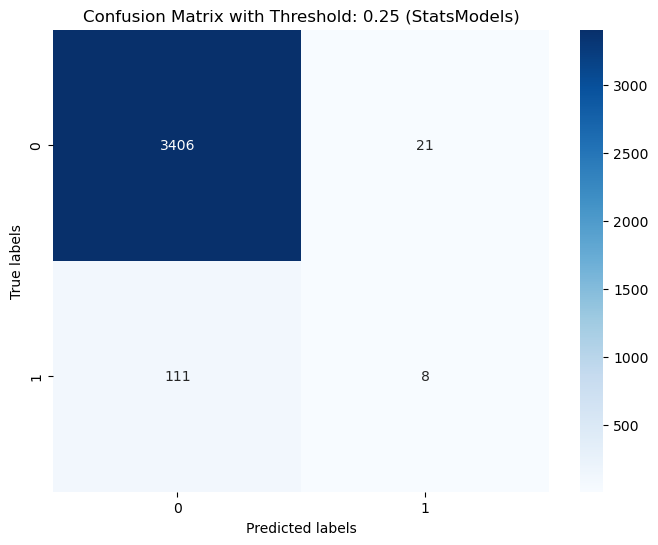

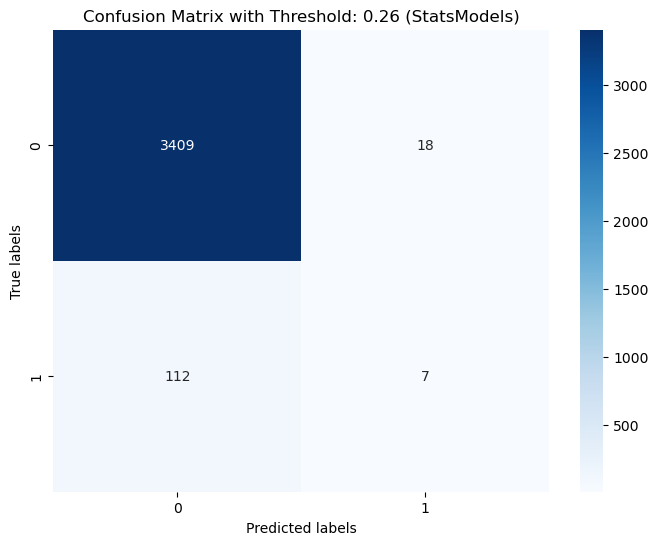

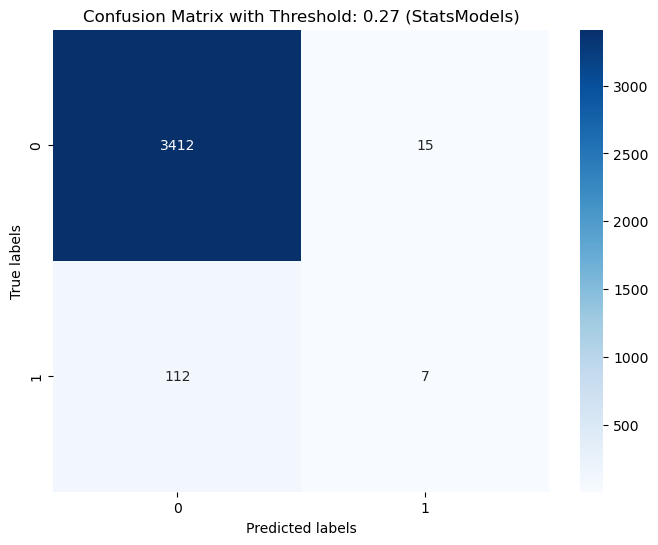

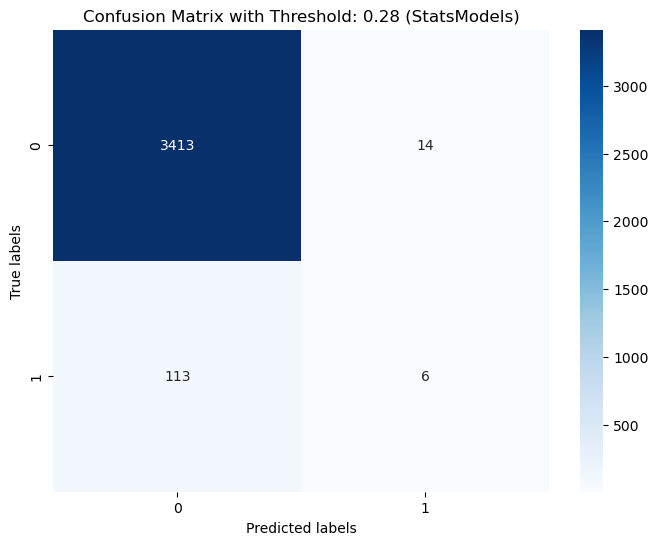

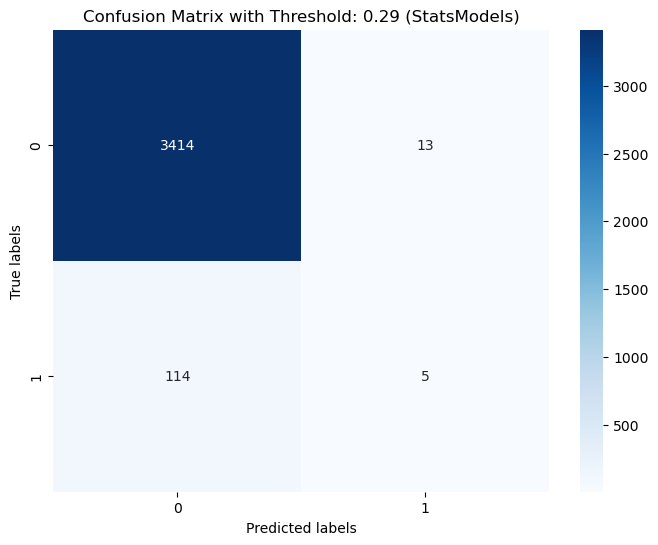

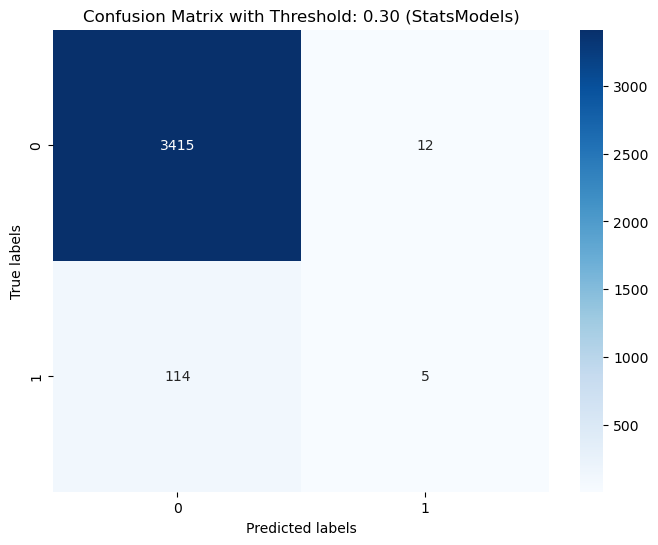

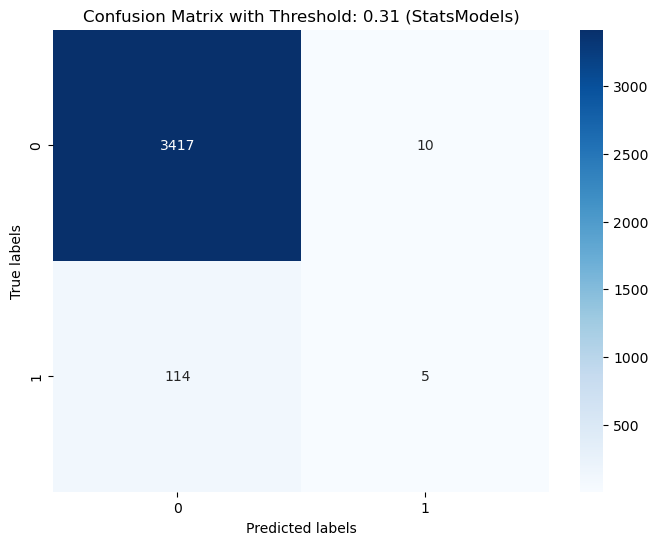

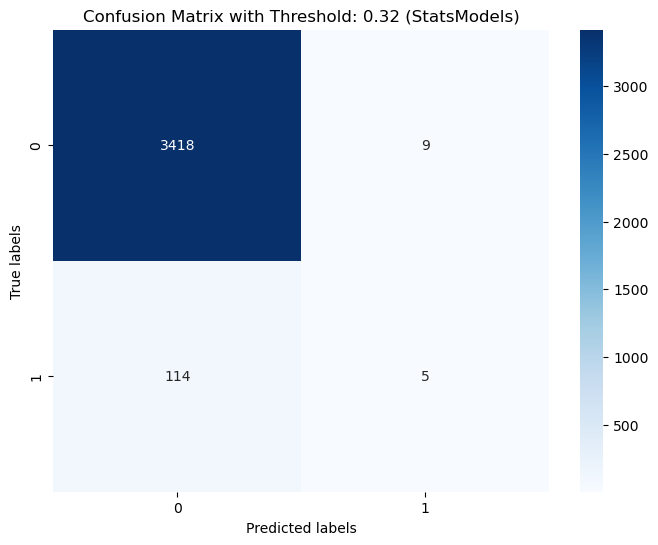

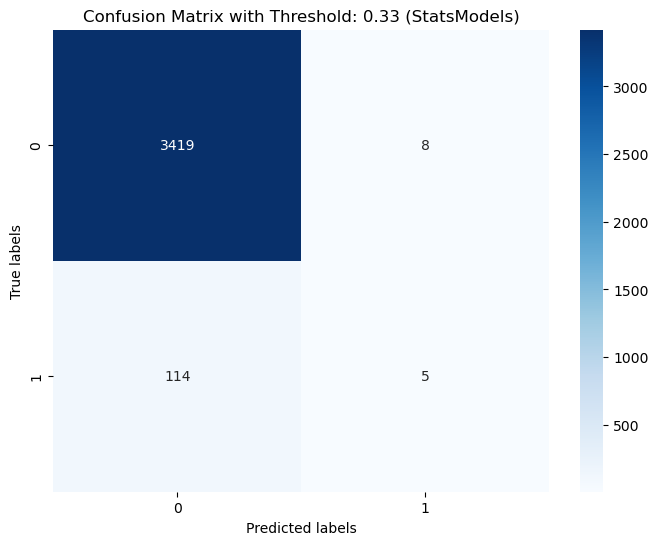

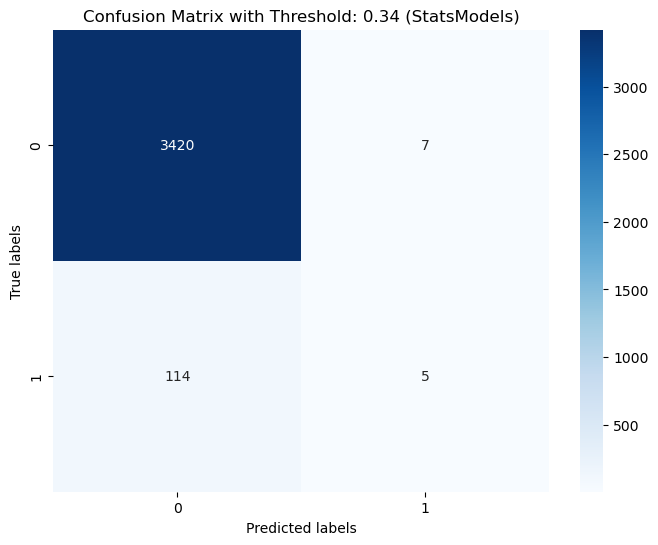

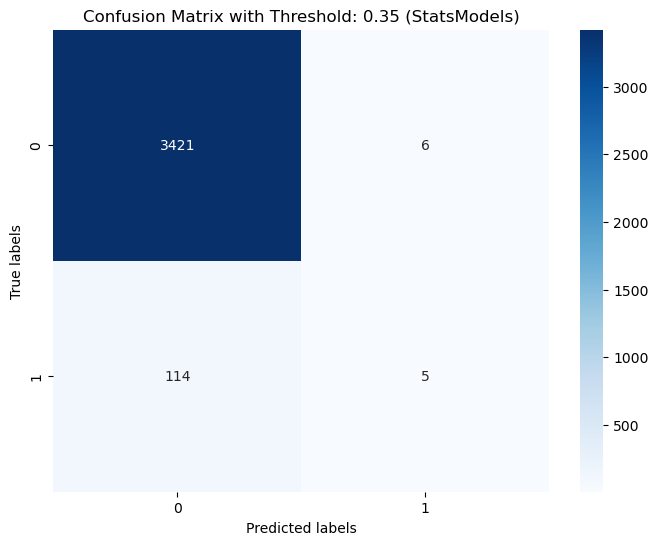

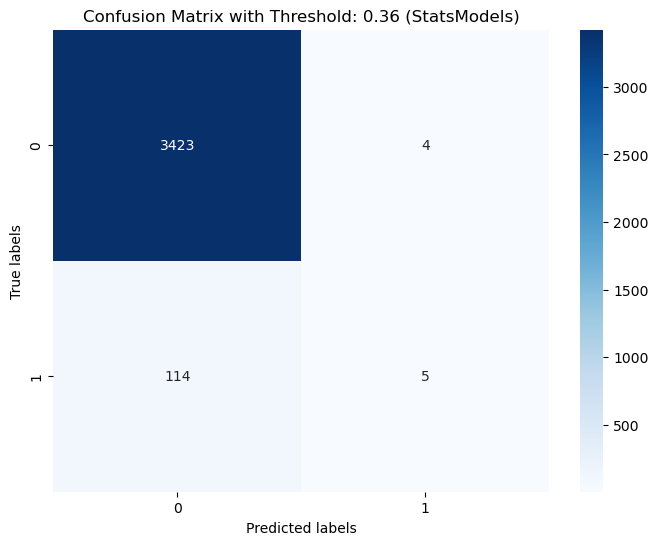

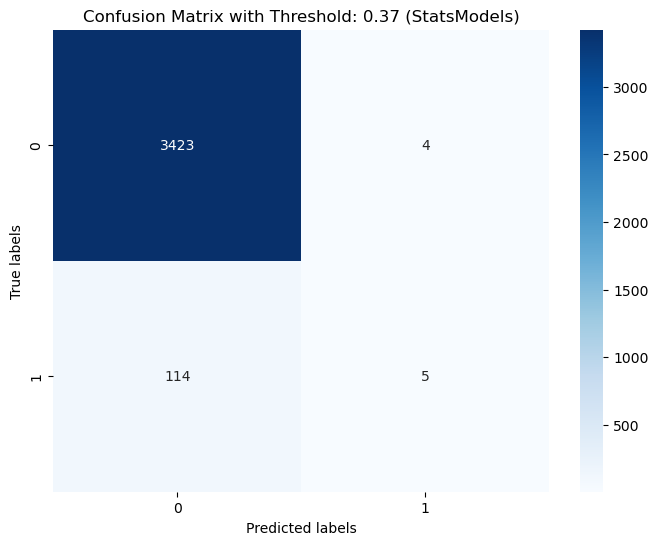

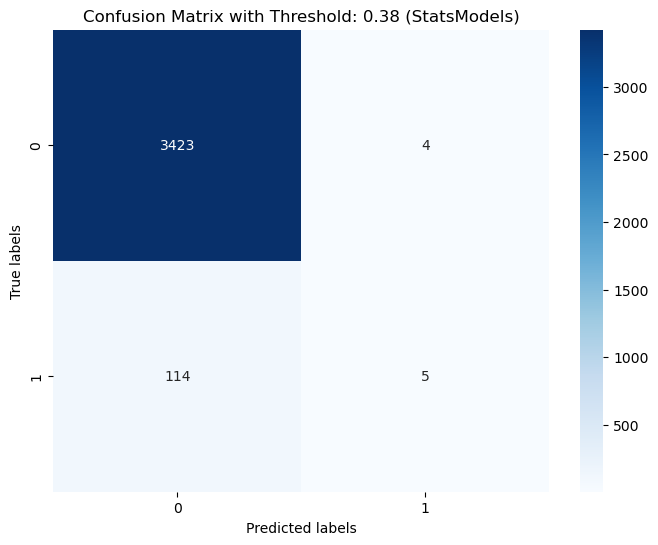

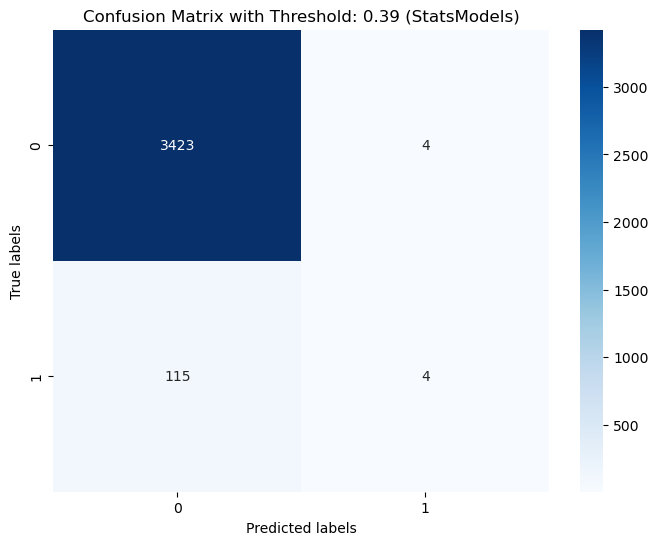

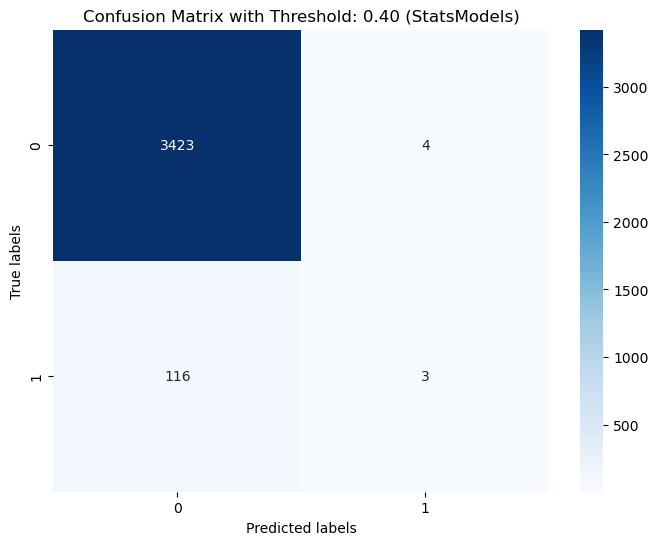

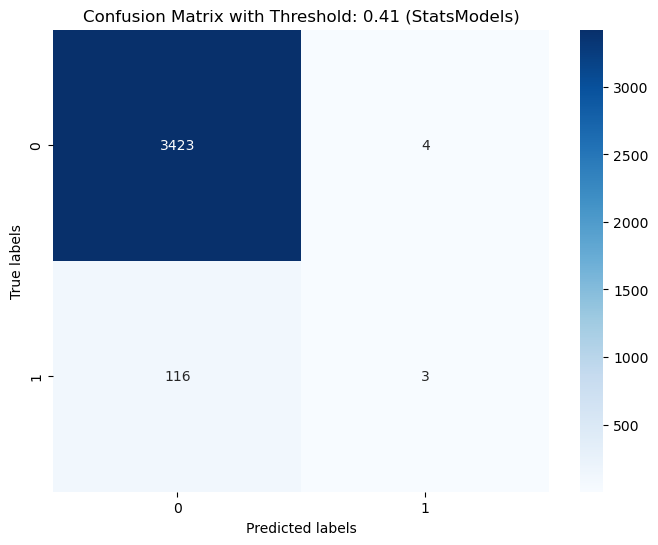

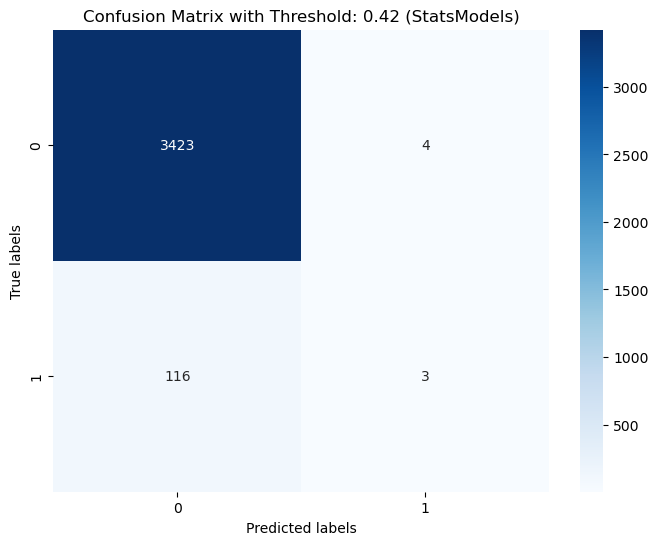

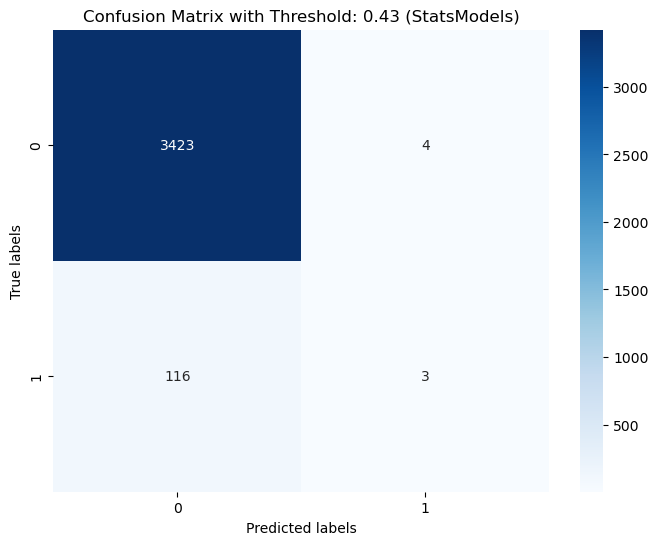

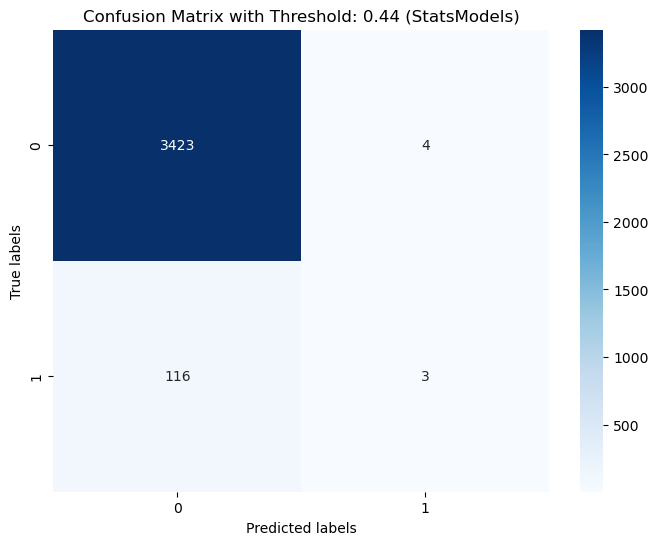

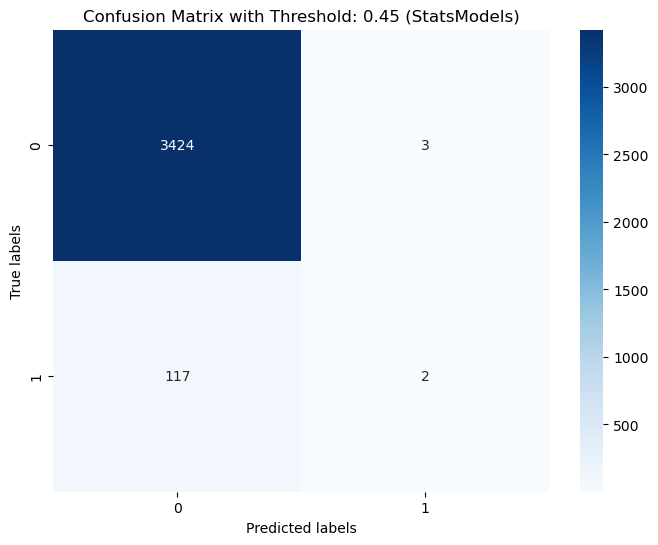

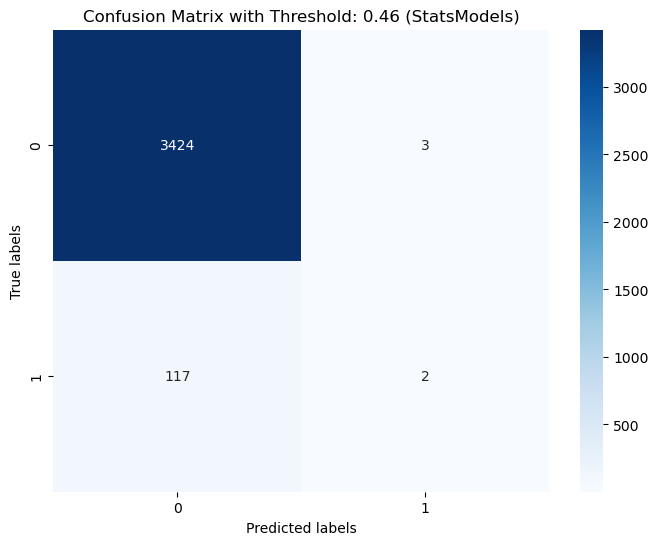

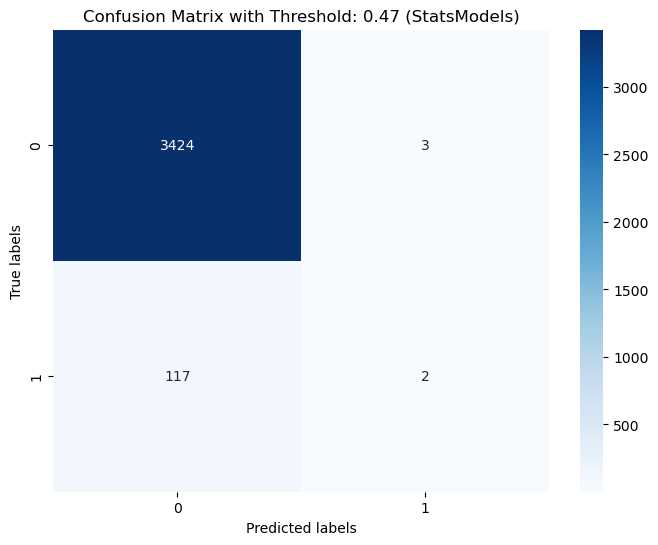

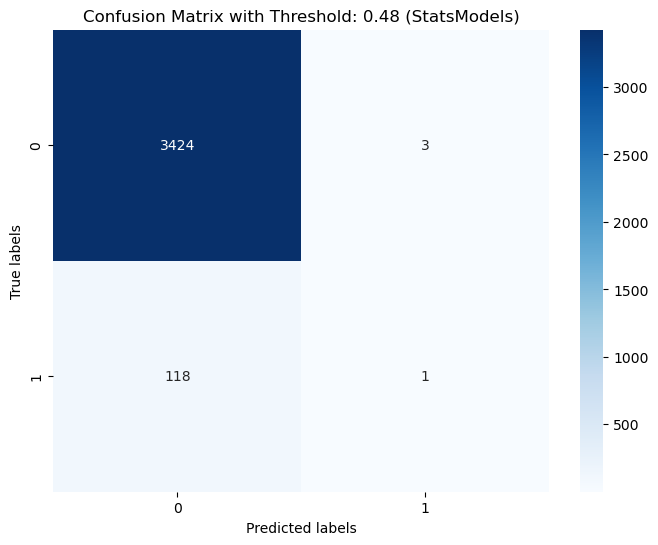

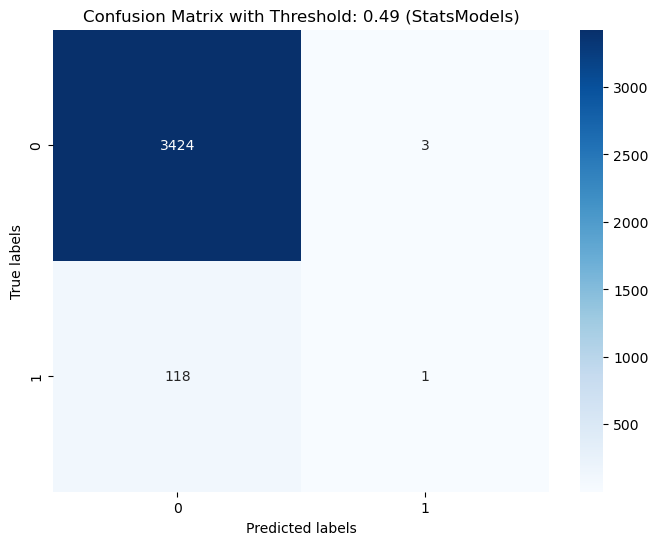

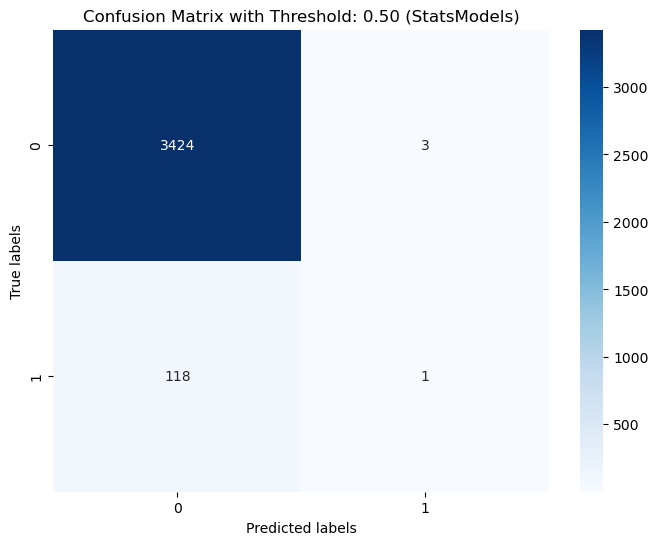

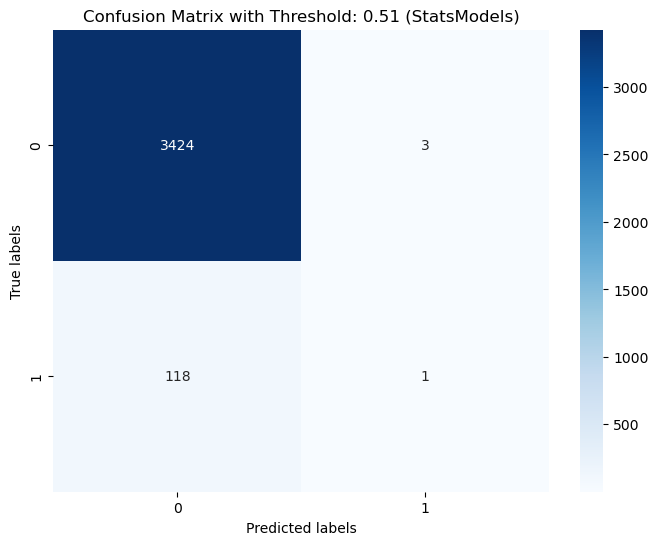

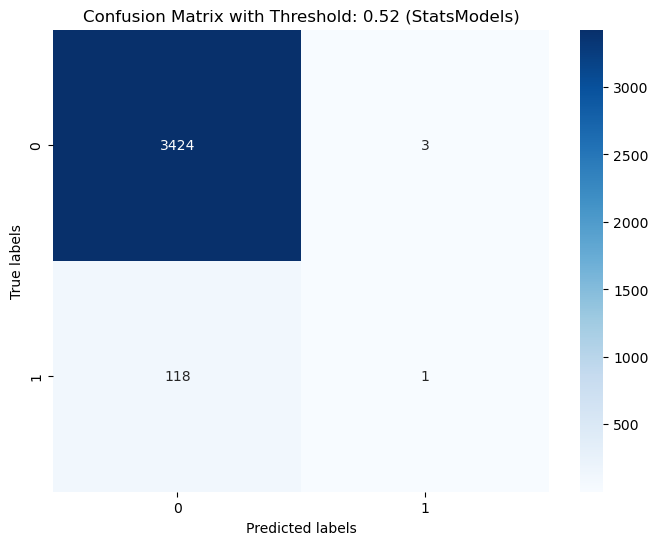

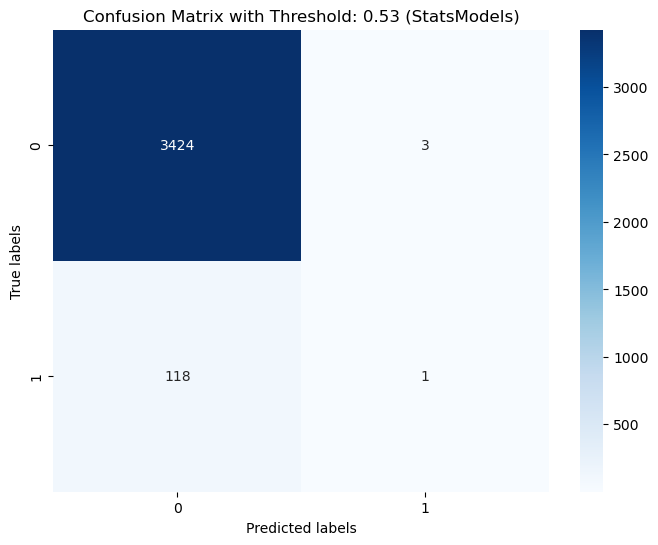

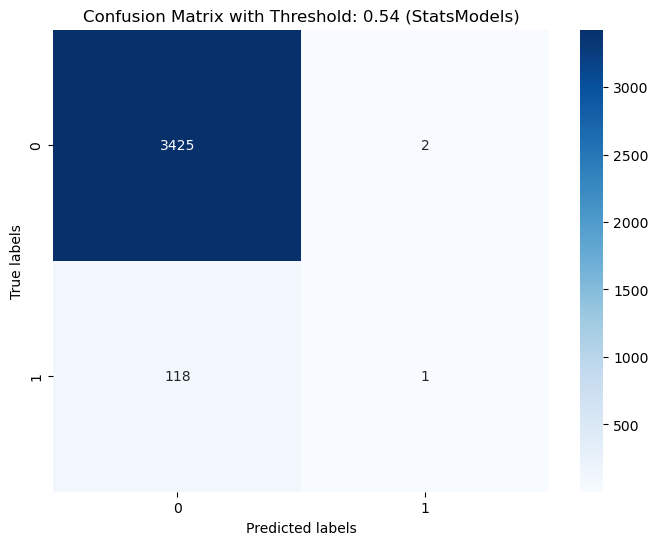

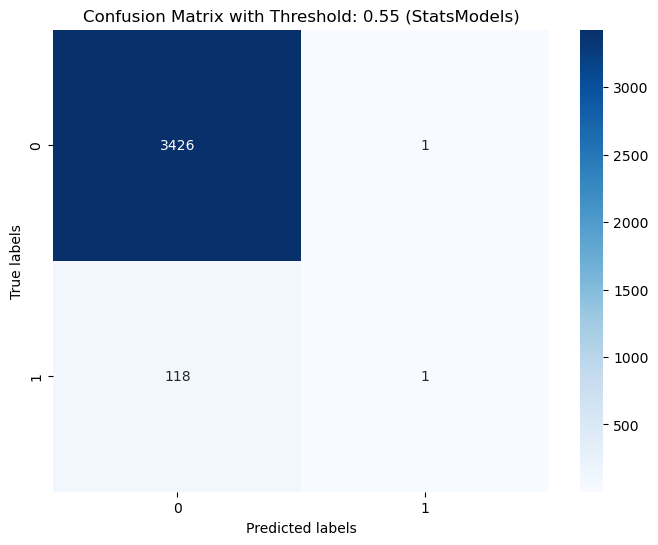

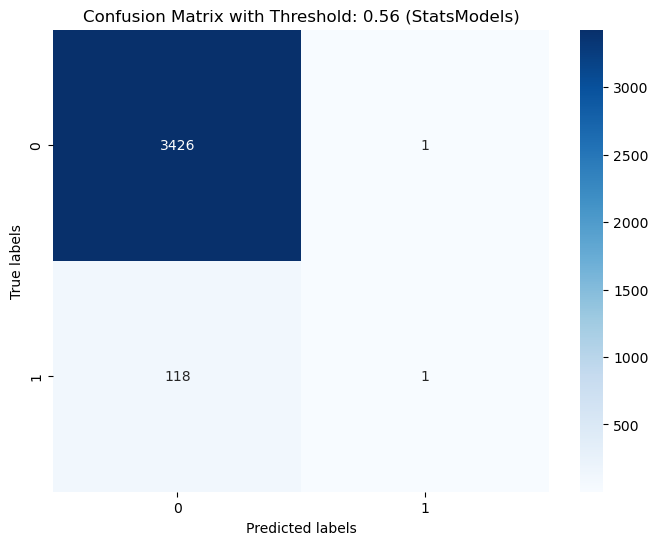

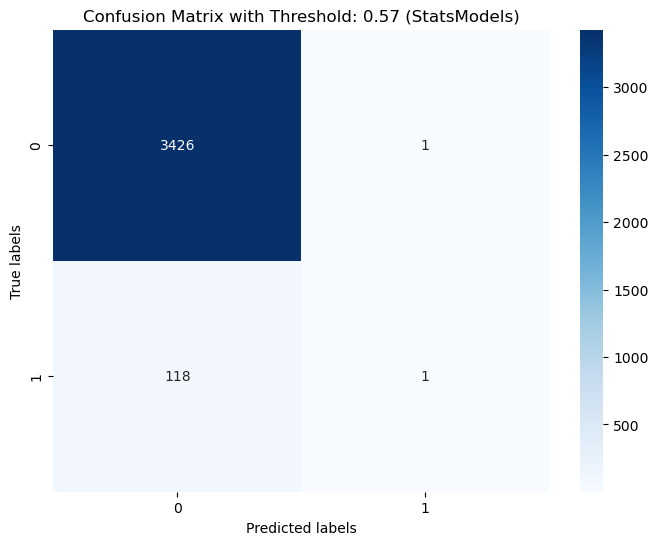

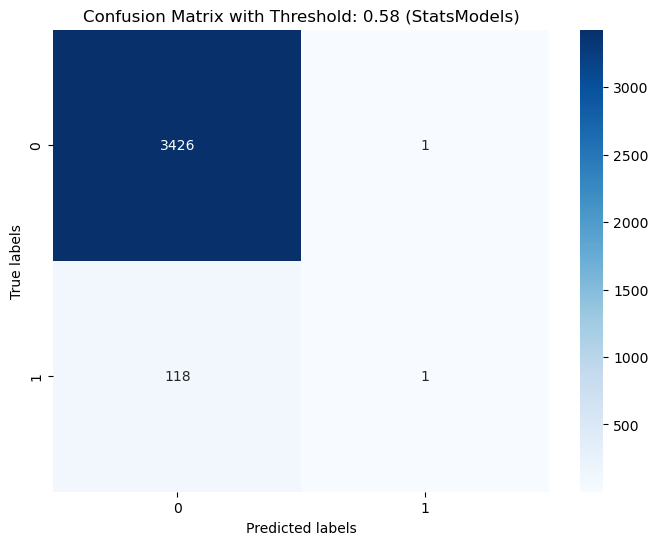

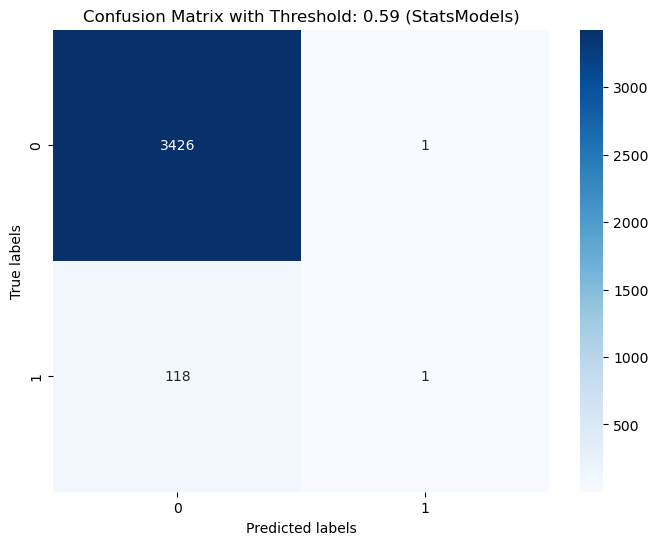

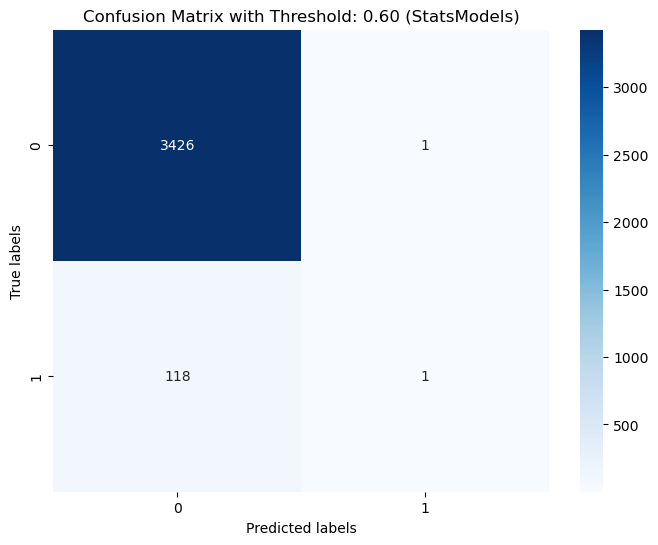

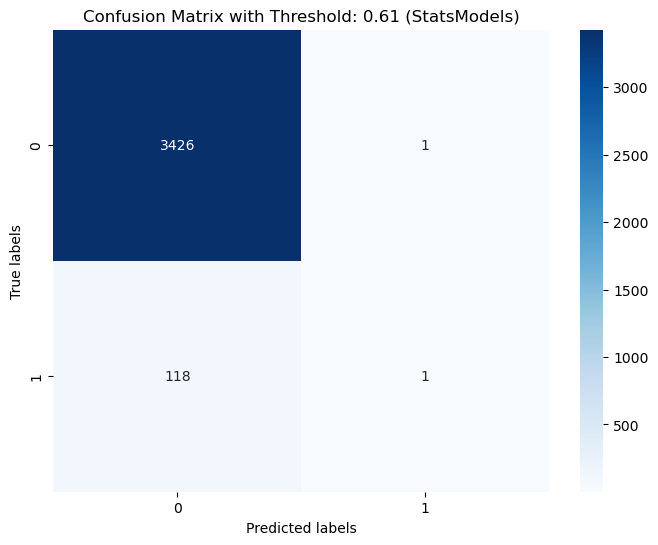

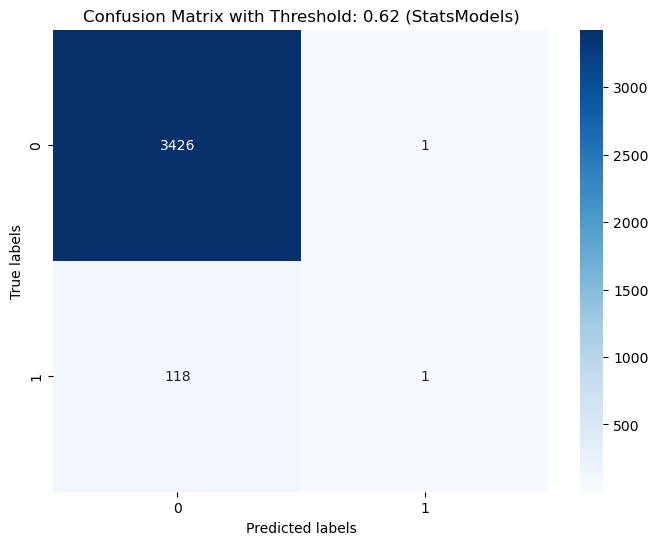

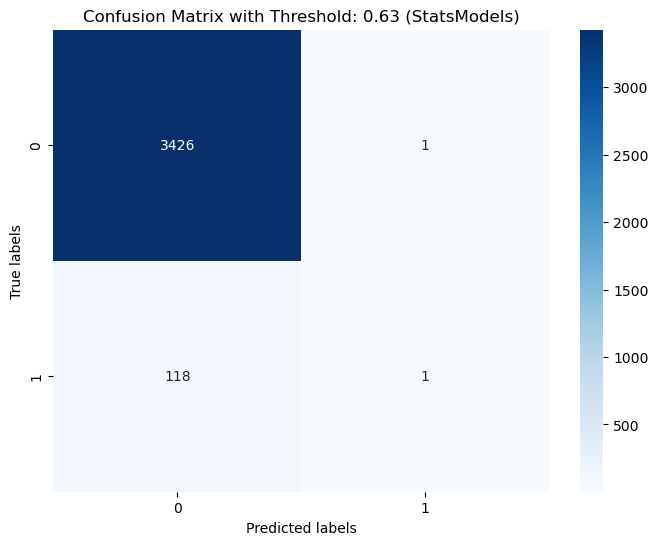

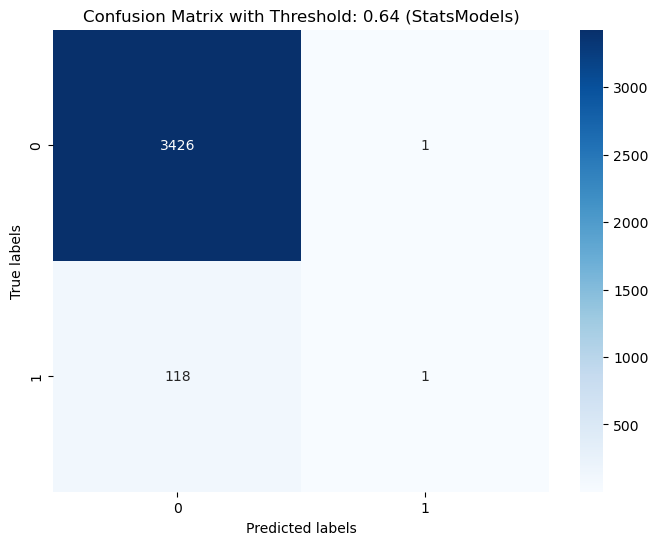

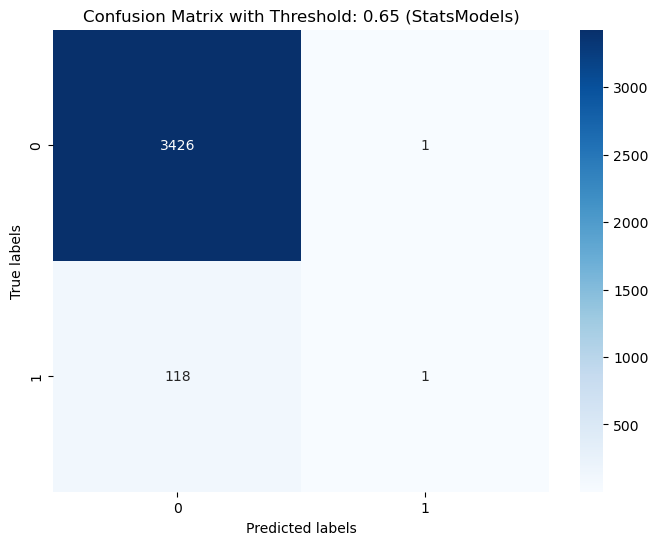

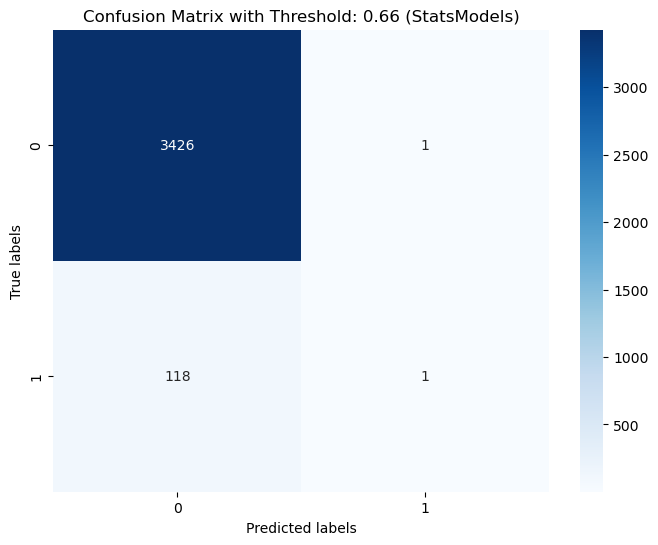

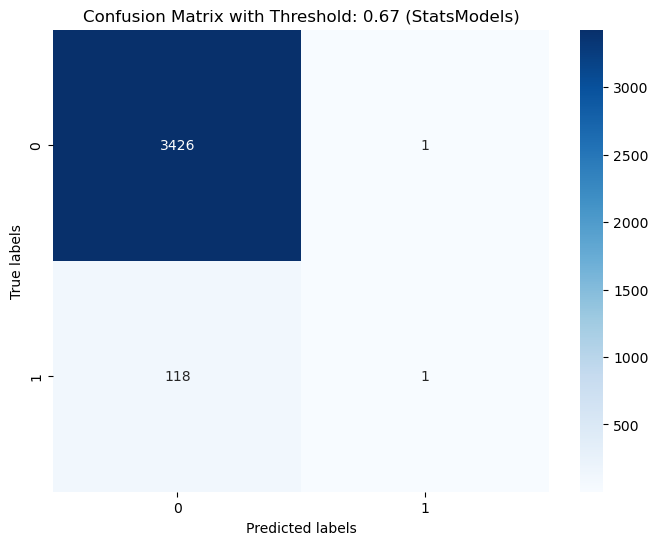

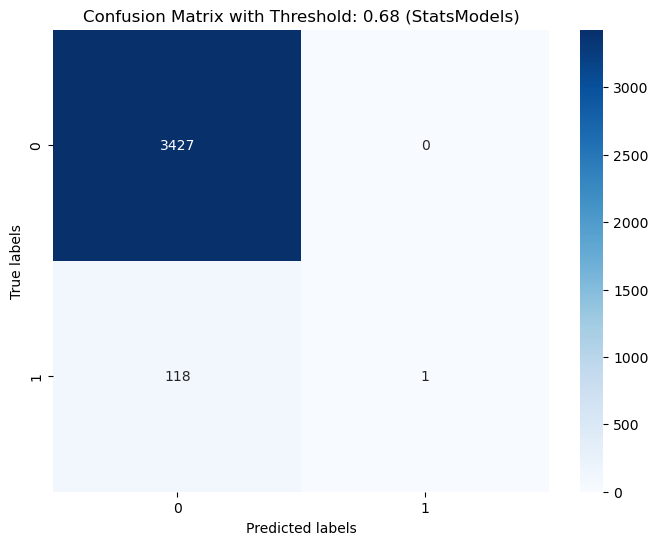

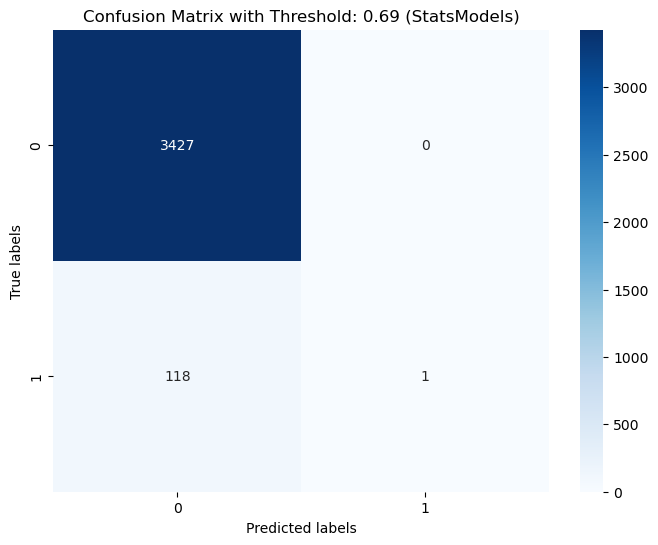

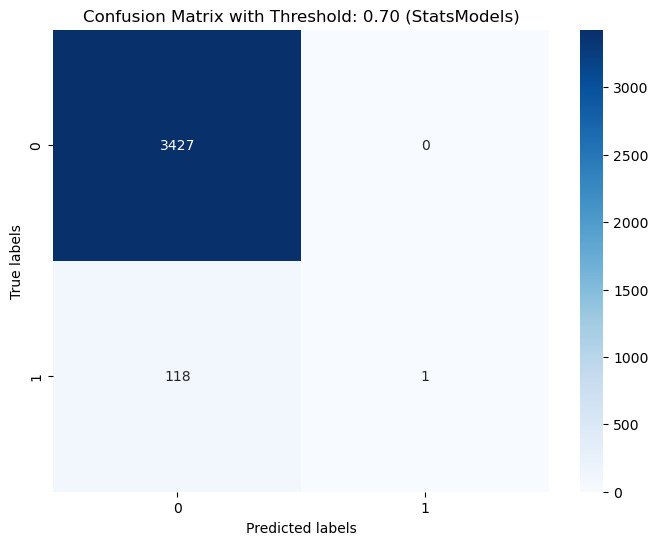

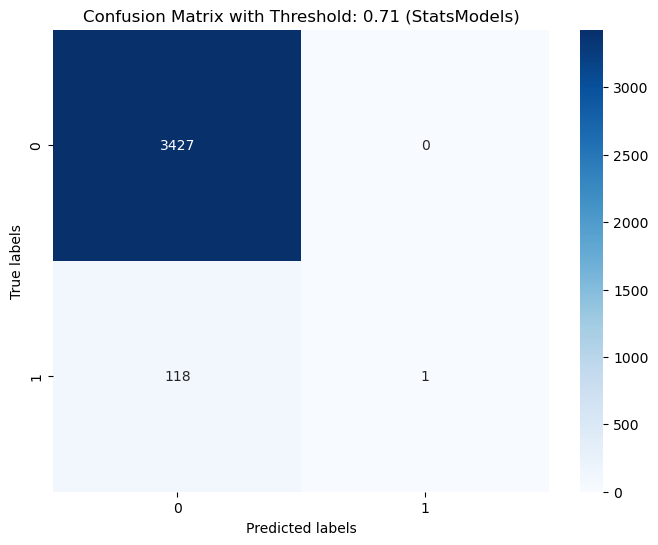

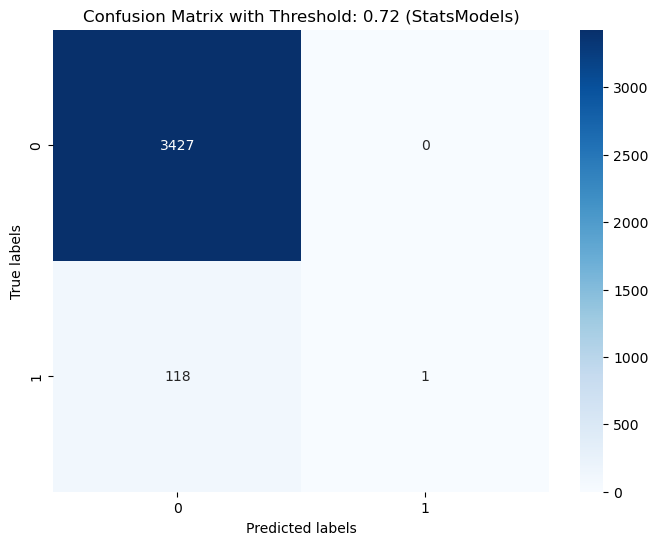

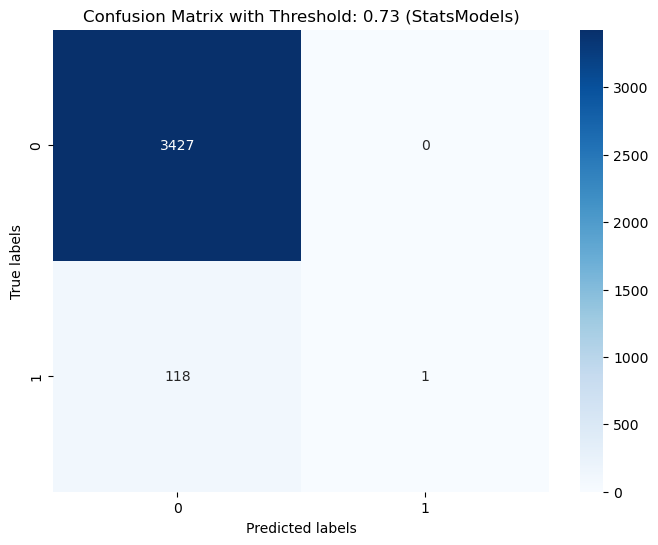

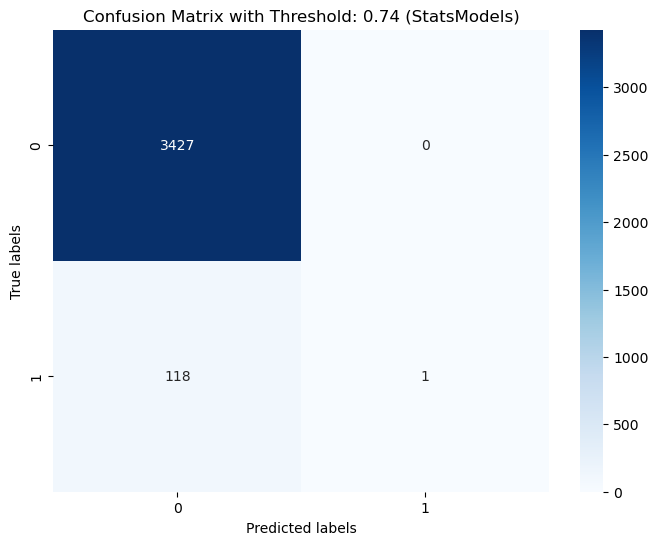

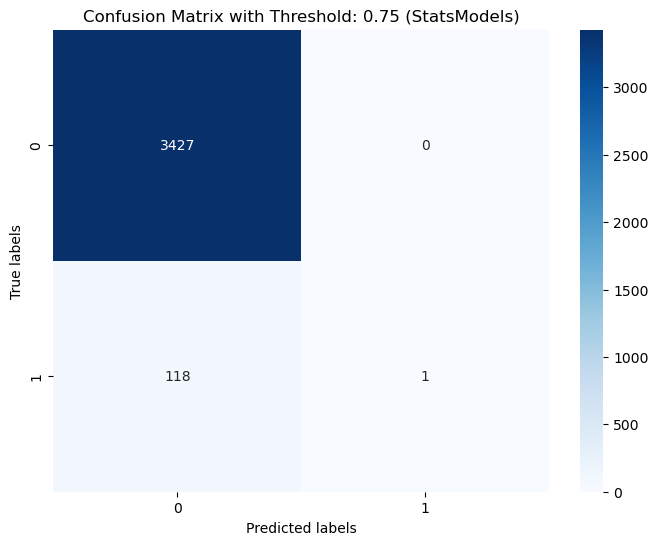

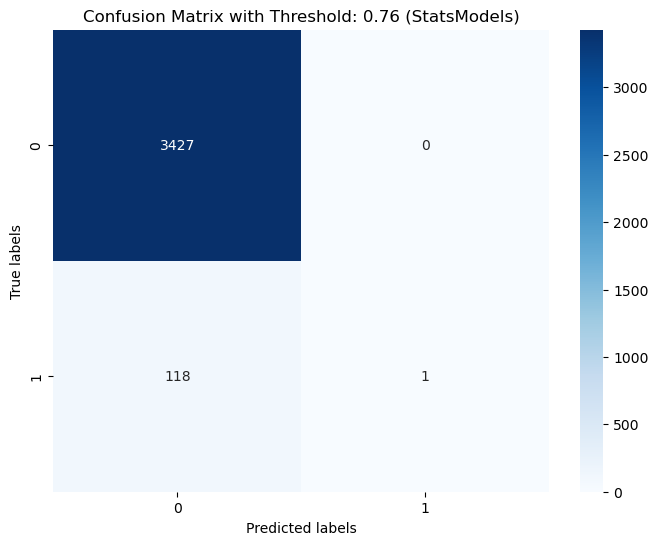

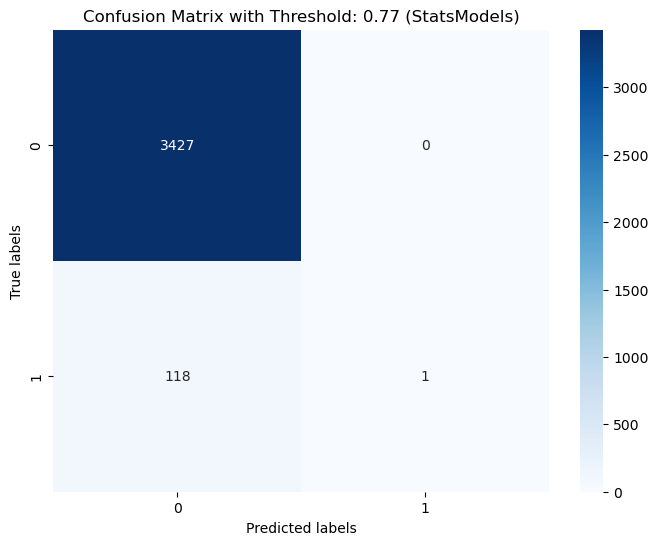

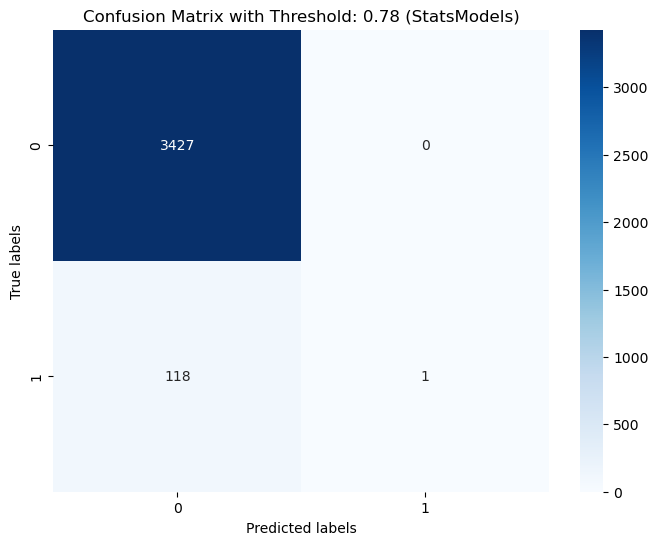

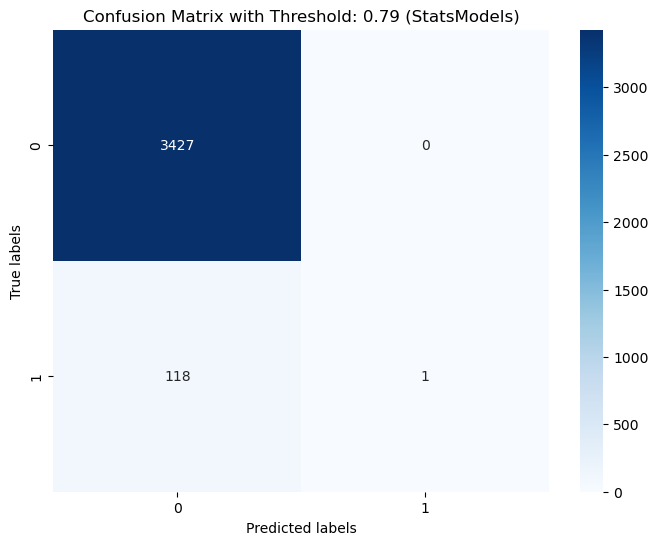

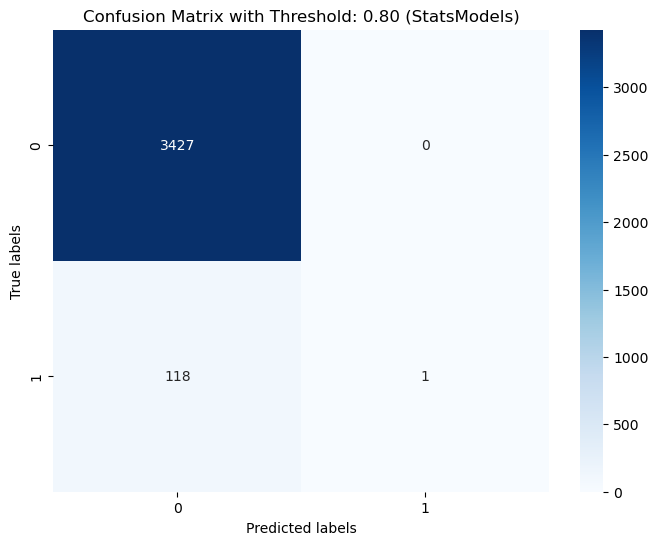

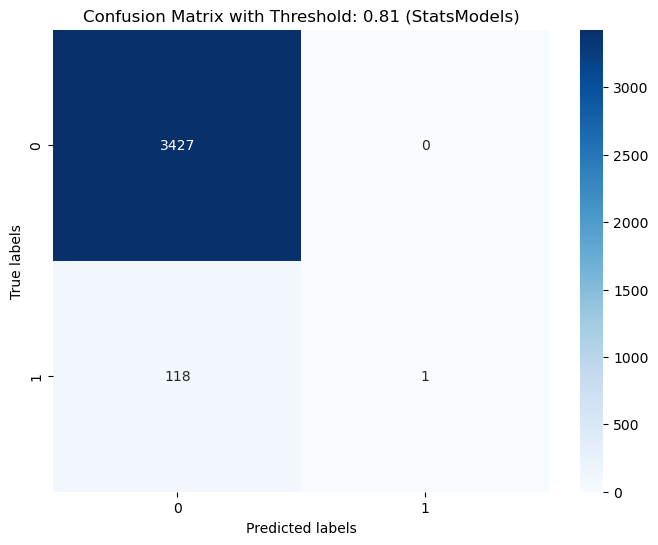

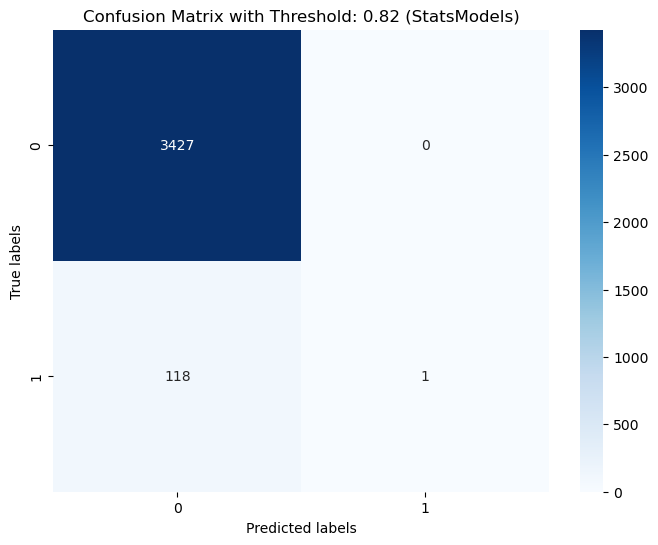

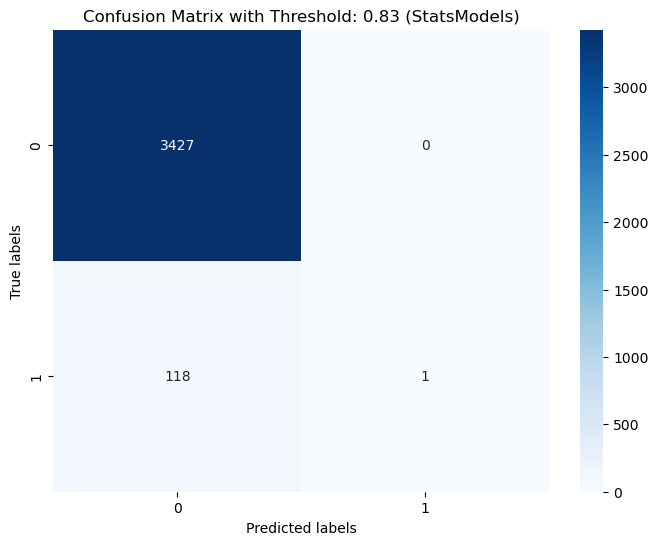

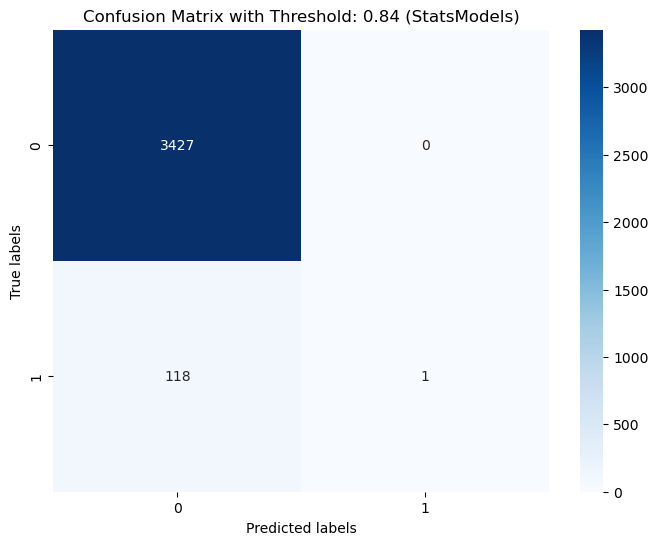

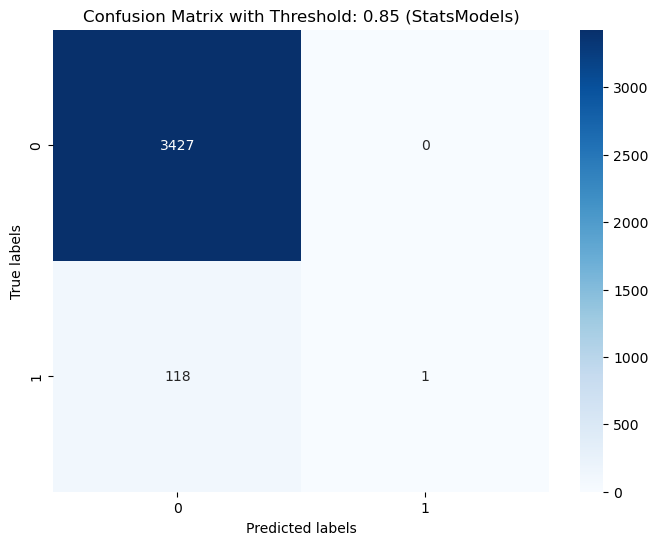

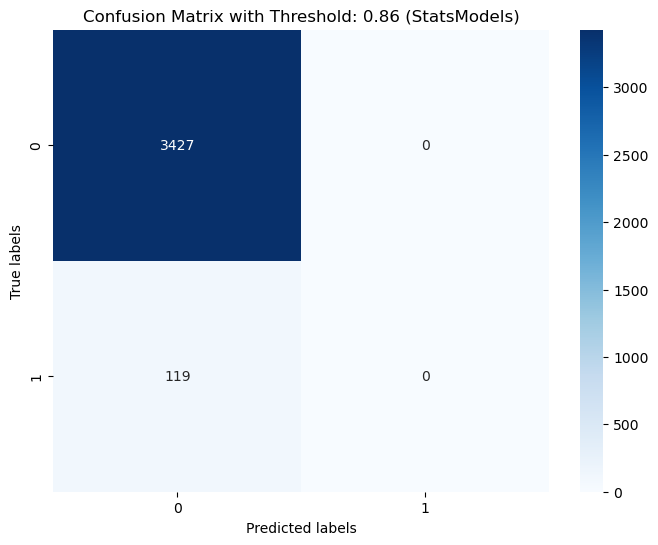

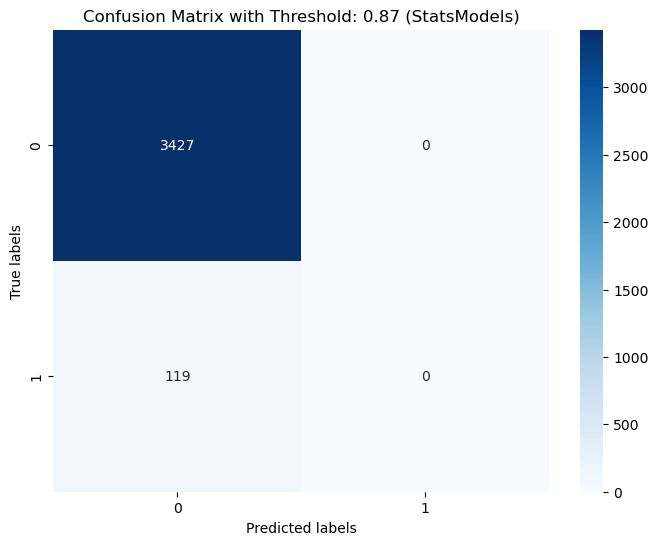

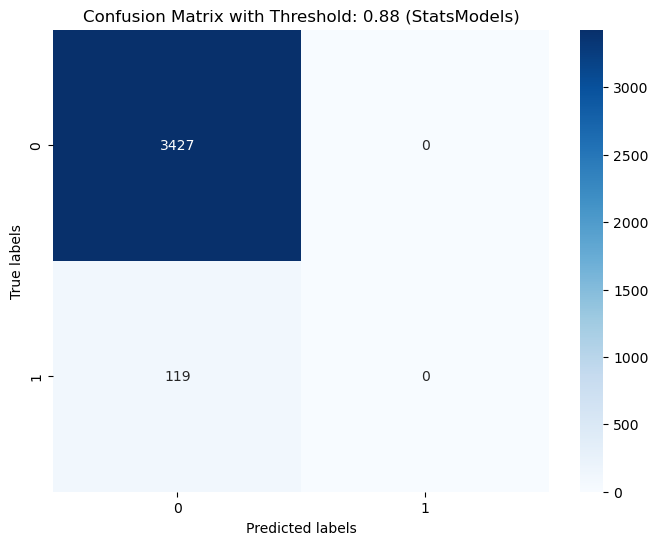

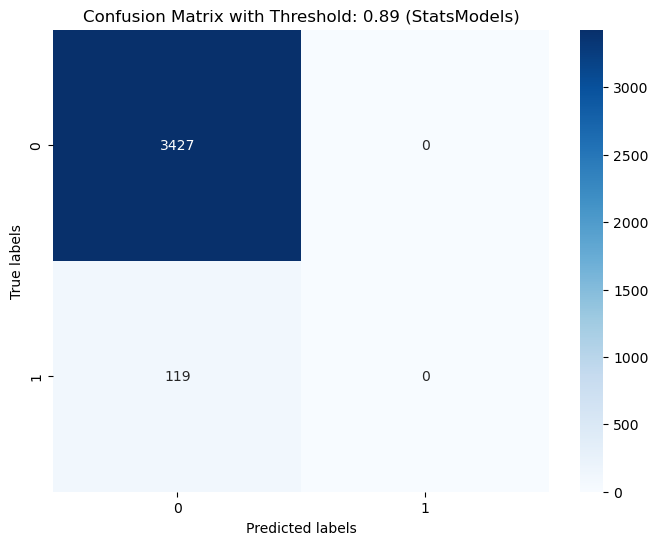

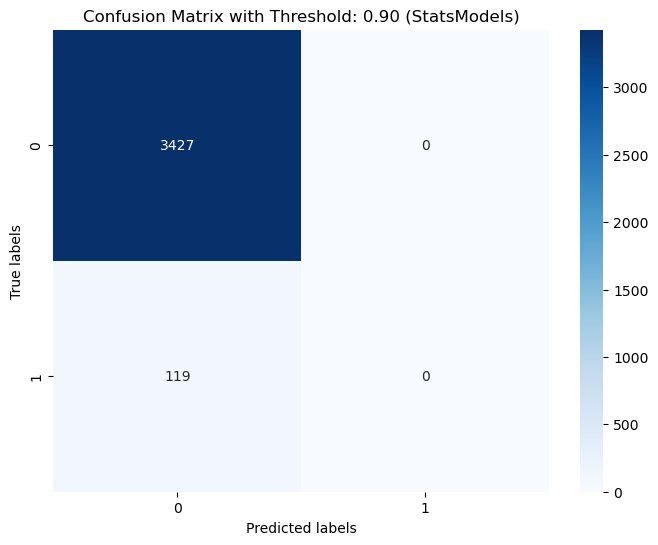

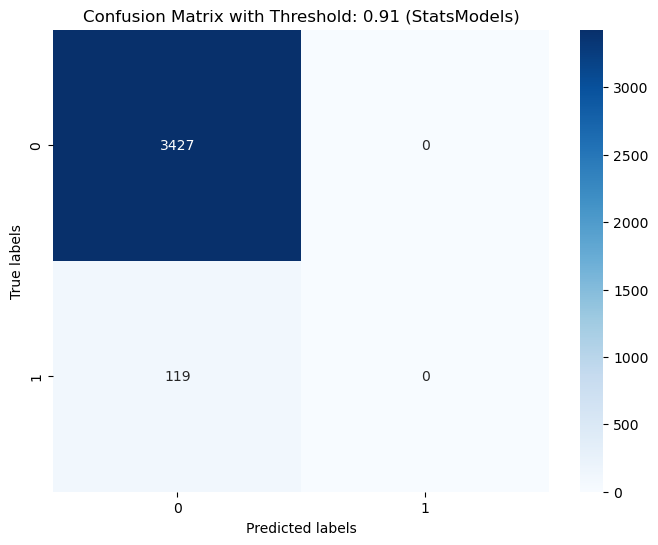

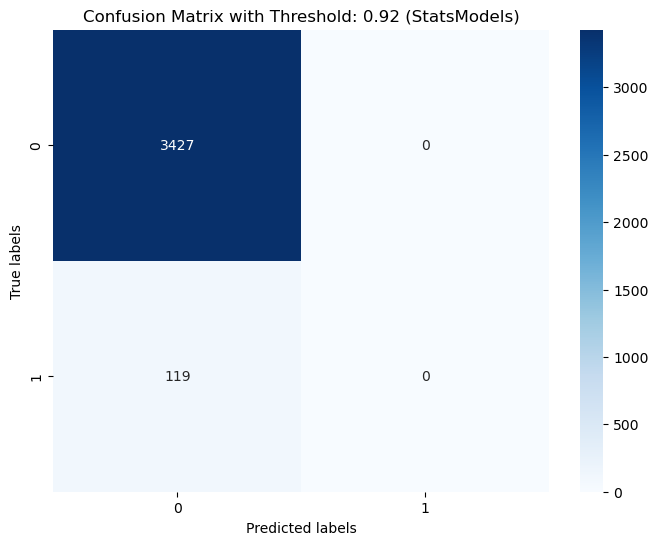

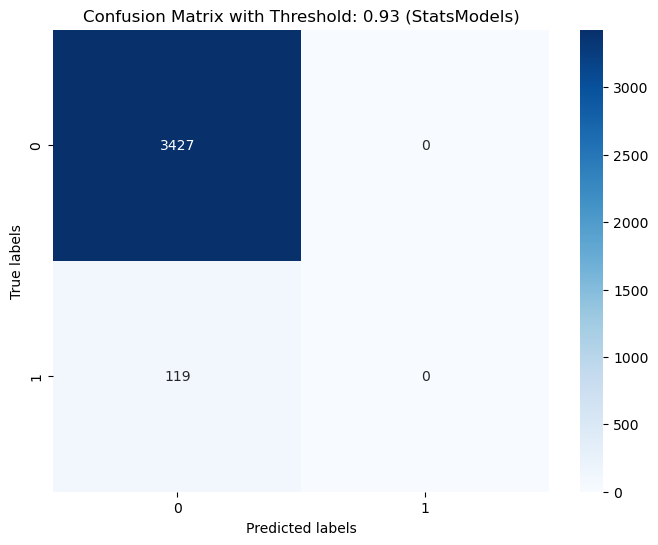

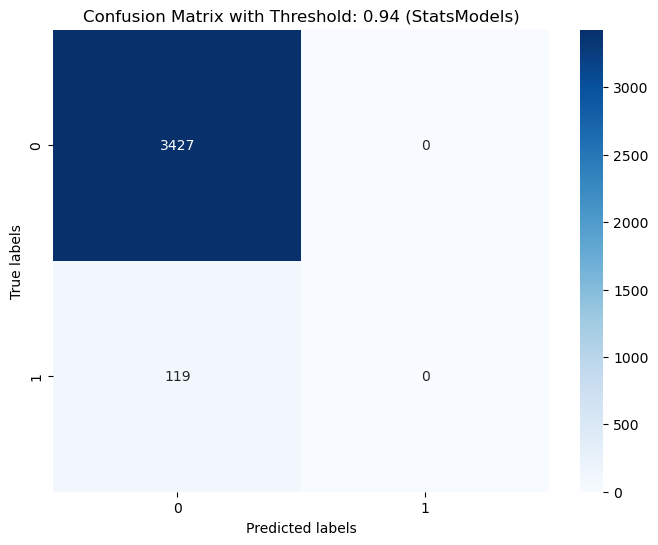

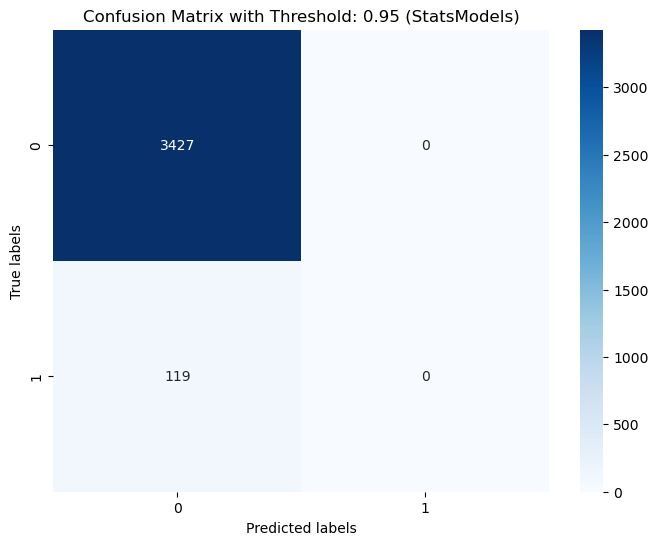

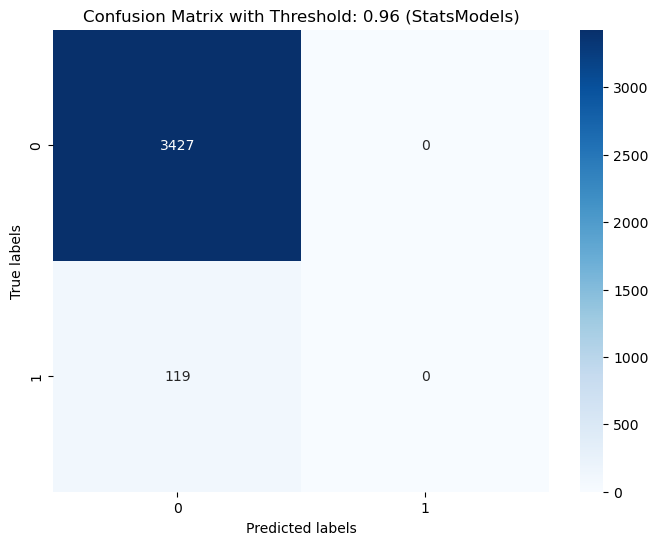

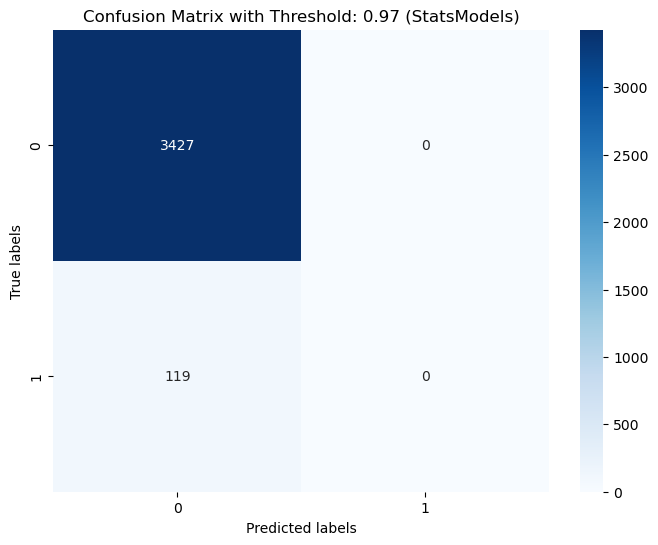

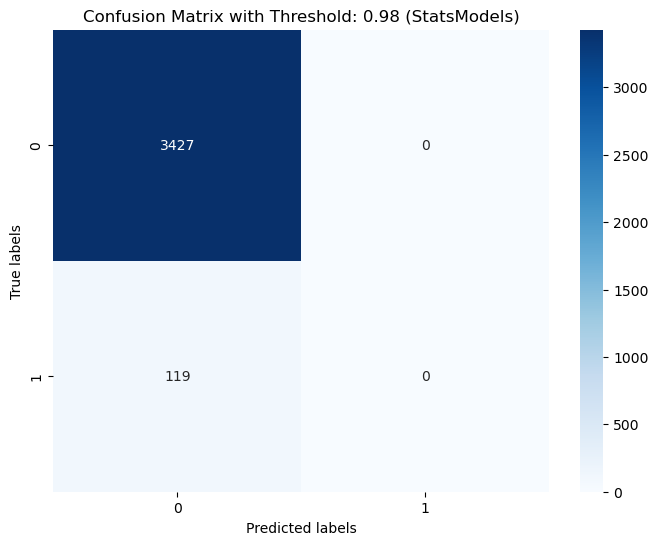

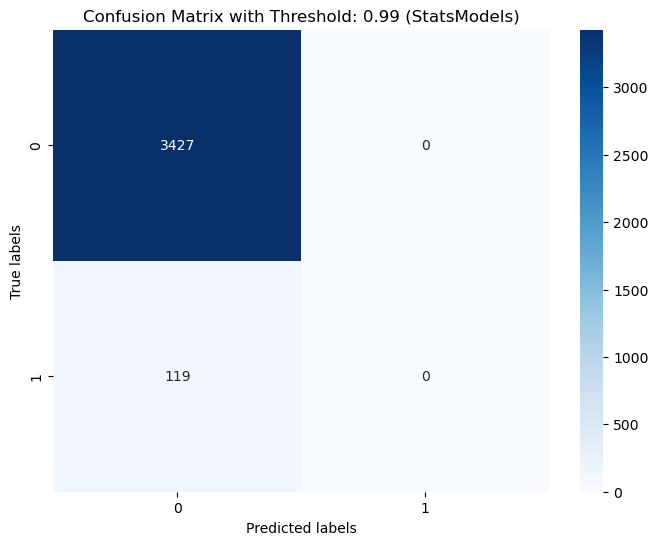

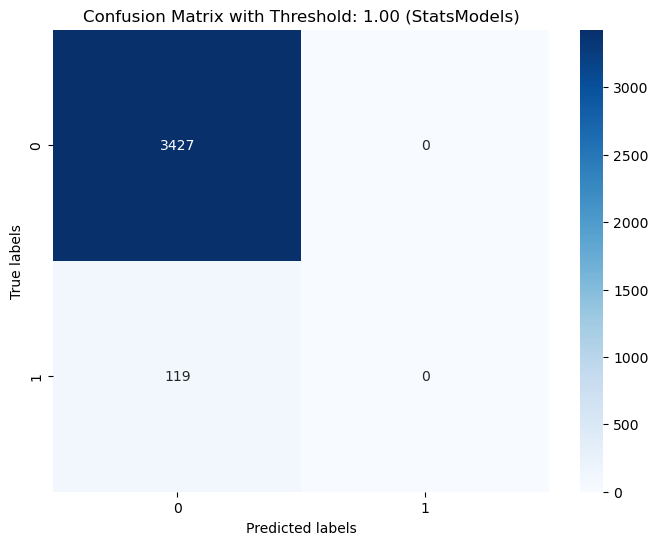

In [25]:
y_proba_sm = model_sm.predict(X_test_sm)

# Defined range of thresholds
thresholds = np.arange(0.01, 1.01, 0.01)

# Iteration through numeric space 
for threshold in thresholds:

    y_pred_custom_threshold_sm = np.where(y_proba_sm >= threshold, 1, 0)
    
 
    conf_matrix_custom_threshold_sm = confusion_matrix(y_test, y_pred_custom_threshold_sm)
    
  
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix_custom_threshold_sm, annot=True, cmap='Blues', fmt='g')
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title(f'Confusion Matrix with Threshold: {threshold:.2f} (StatsModels)')
    plt.show()


Models beetwen threshold 0,02 and 0,03 seem to be the best optimzed. Let's chceck a models beetwen this numeric space


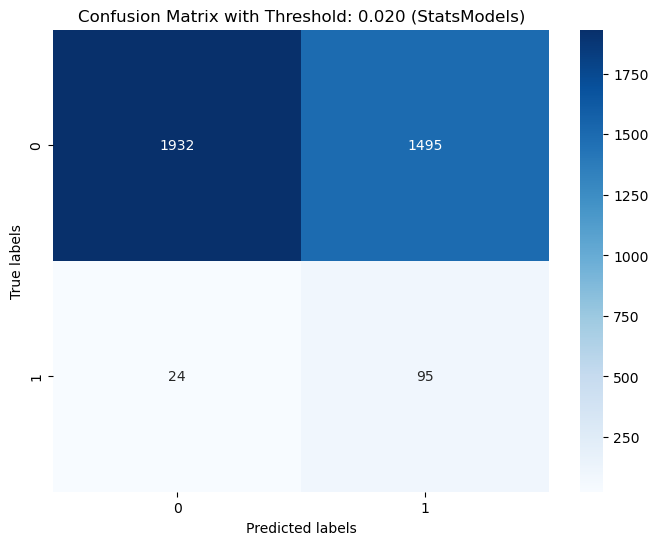

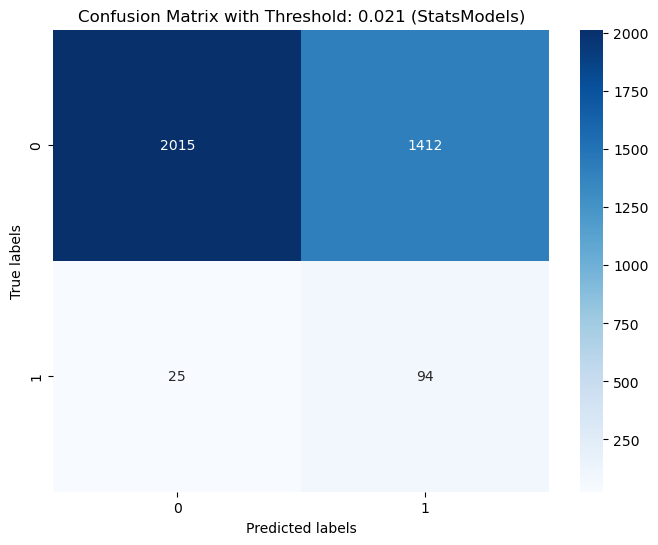

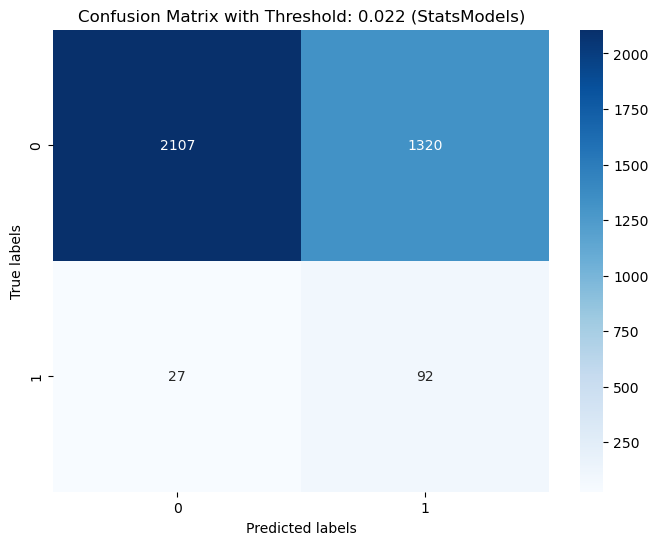

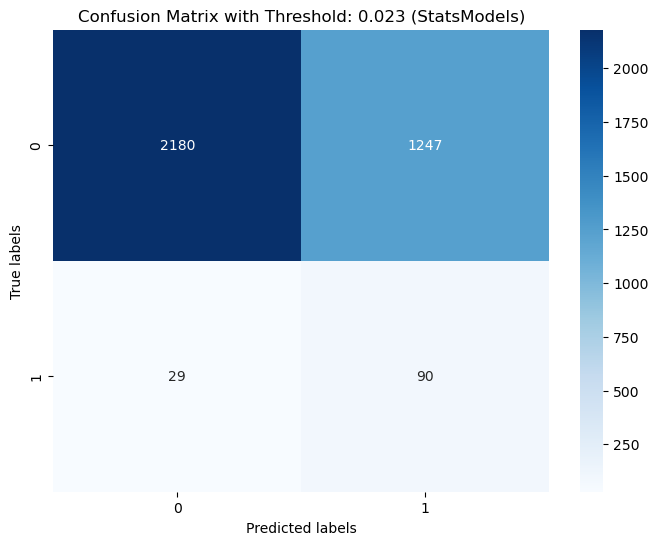

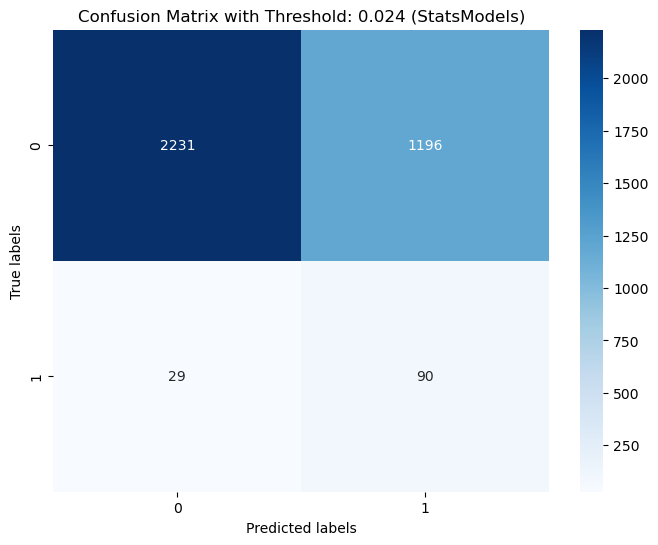

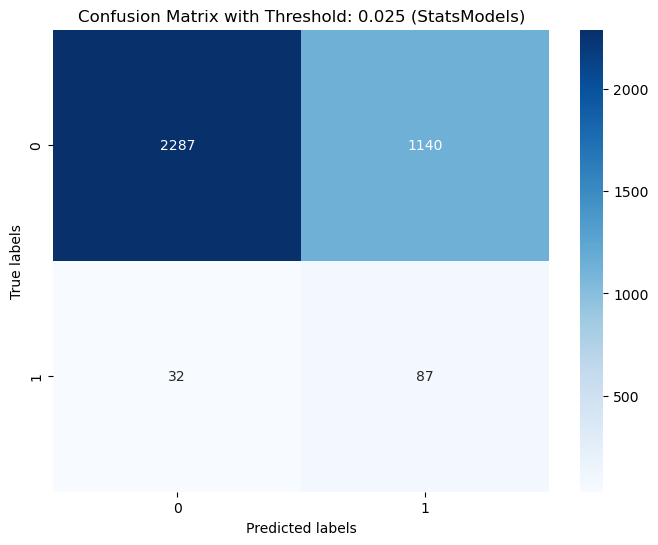

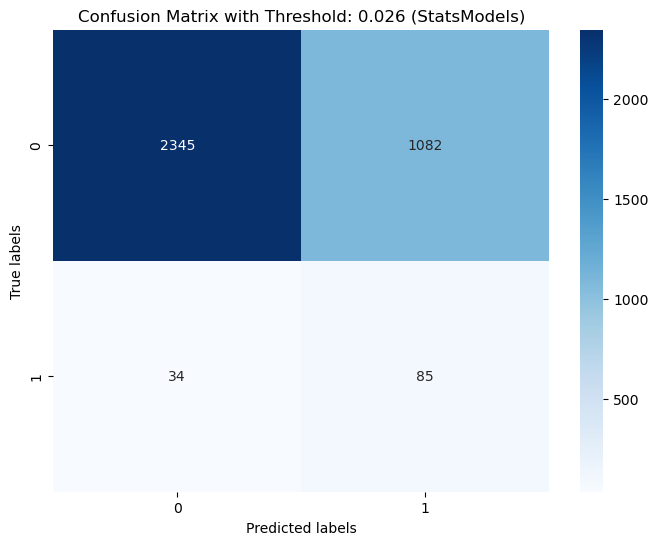

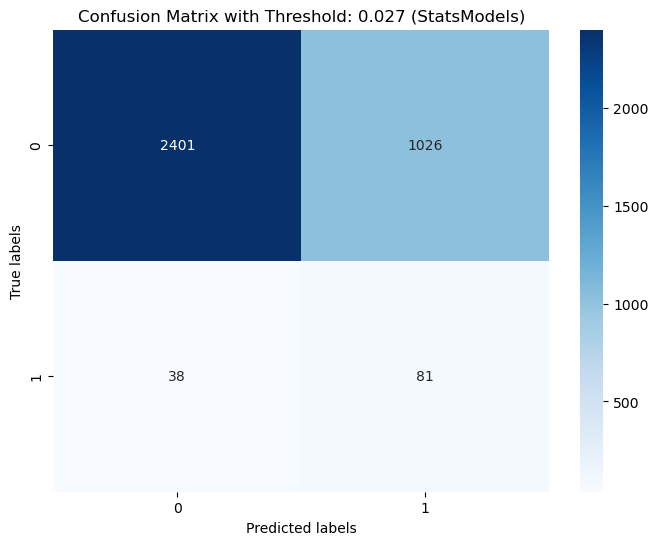

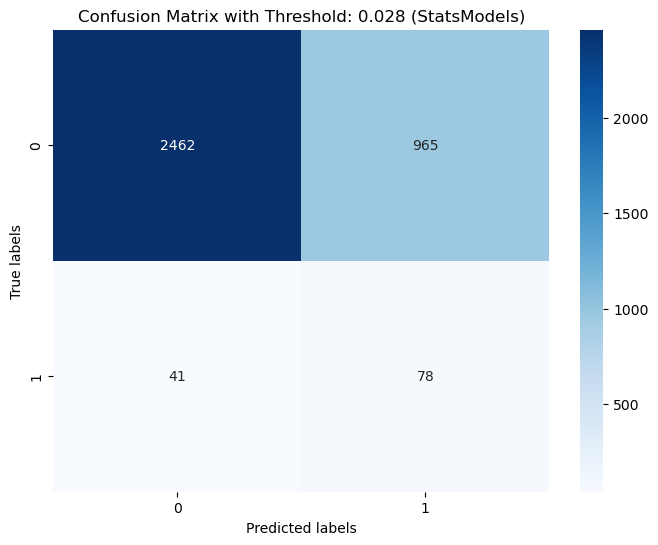

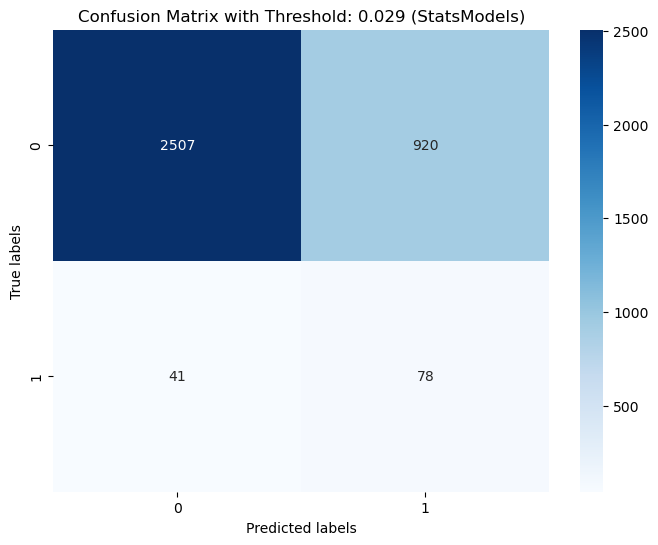

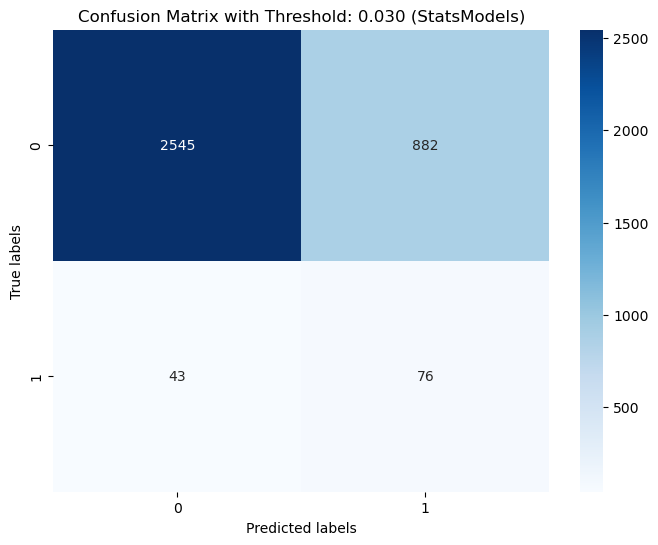

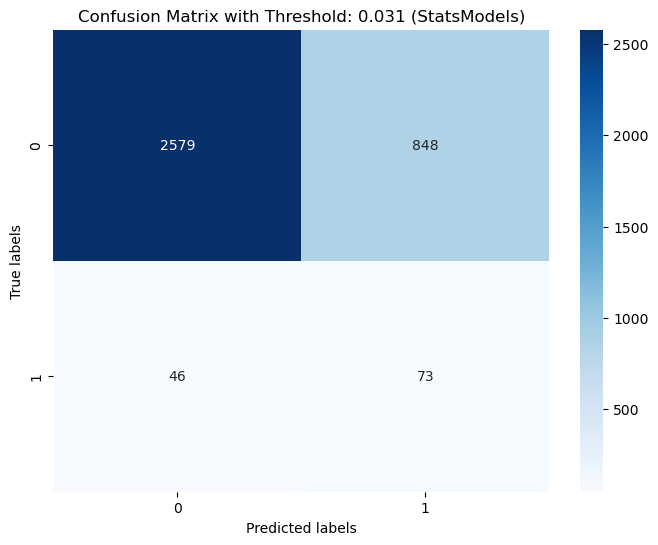

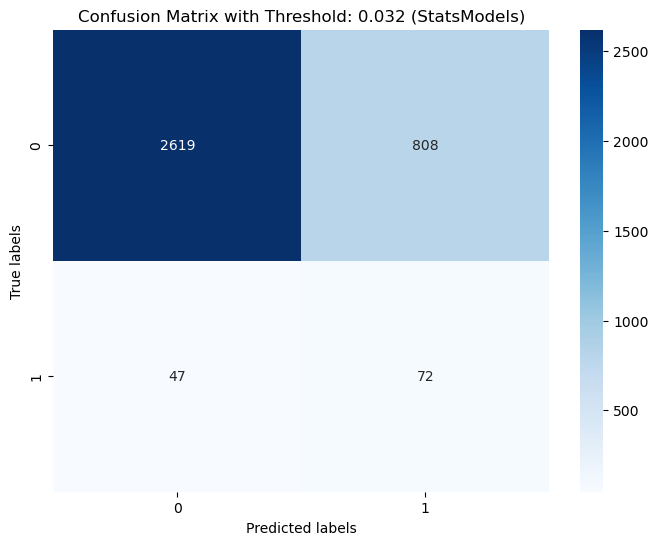

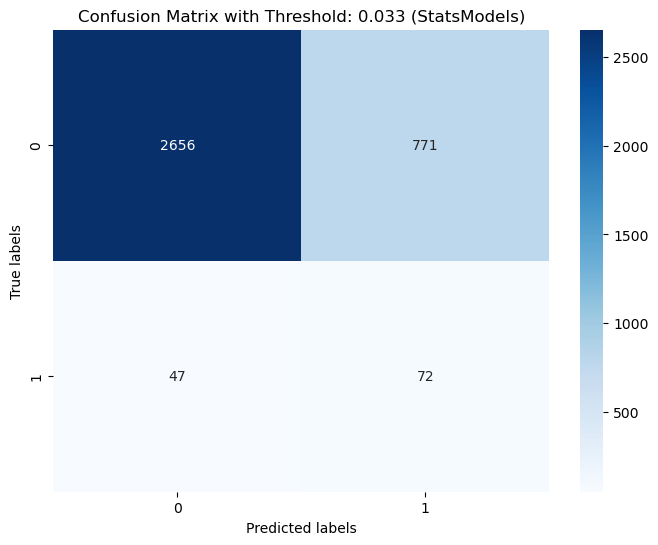

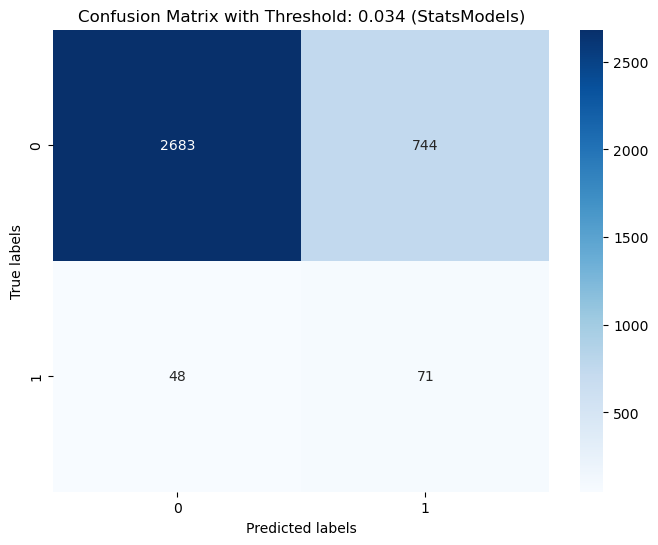

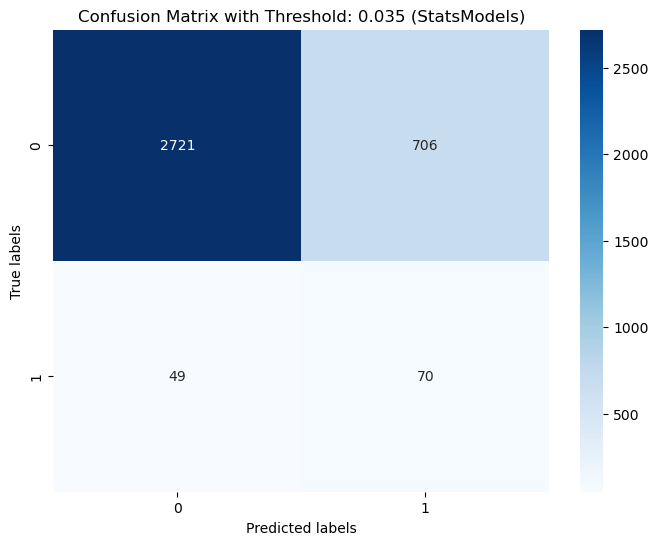

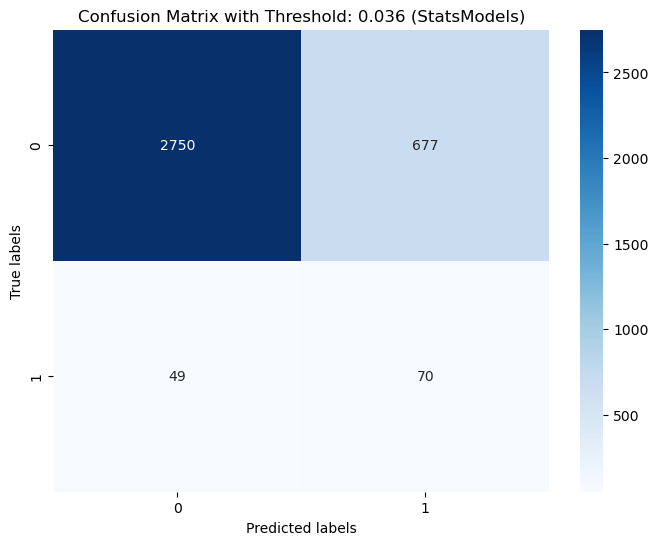

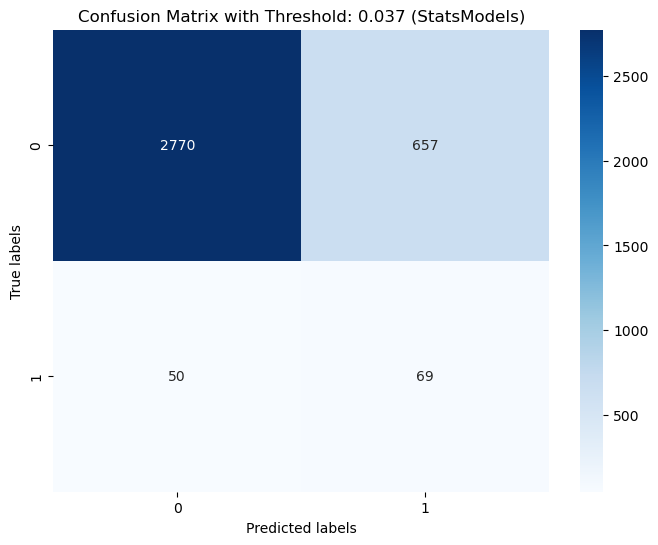

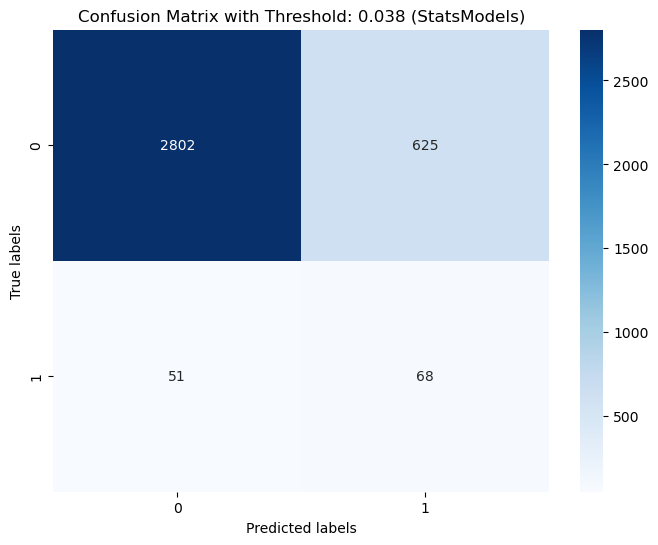

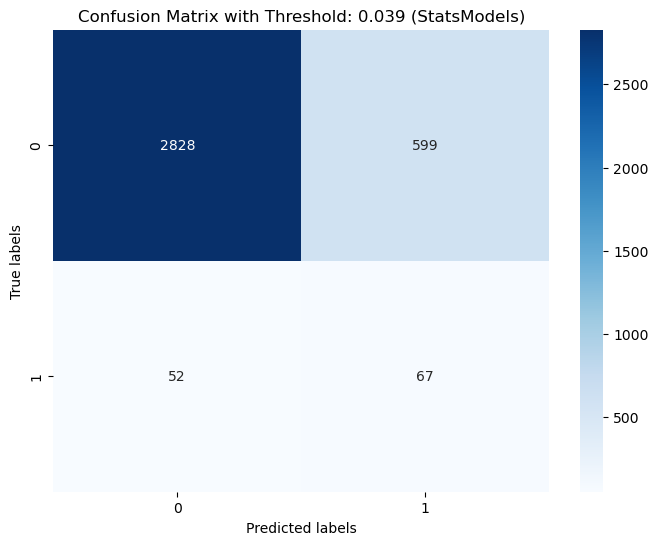

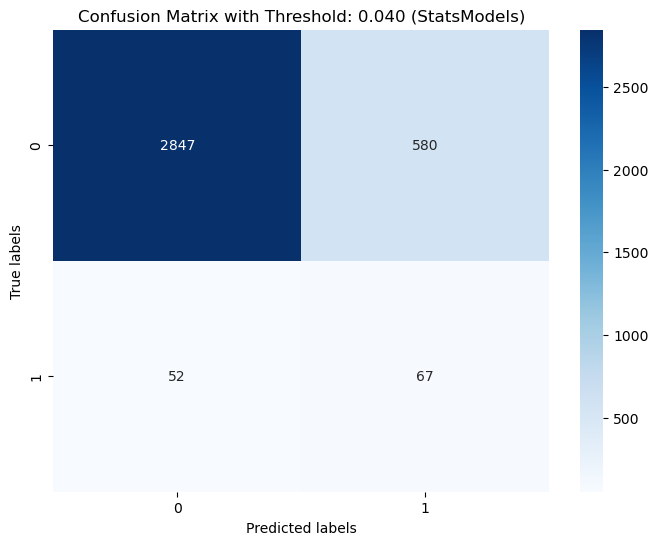

In [26]:
# Iteration through tighter range of thresholds
thresholds_fine = np.arange(0.02, 0.041, 0.001)


thresholds_fine
for threshold in thresholds_fine:
    
    y_pred_custom_threshold_sm = np.where(y_proba_sm >= threshold, 1, 0)
    
    
    conf_matrix_custom_threshold_sm = confusion_matrix(y_test, y_pred_custom_threshold_sm)
    
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix_custom_threshold_sm, annot=True, cmap='Blues', fmt='g')
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title(f'Confusion Matrix with Threshold: {threshold:.3f} (StatsModels)')
    plt.show()

Model with threshold equal ot 0,026 seems to be the most accurate based on our strategy predictions

Optimization terminated successfully.
         Current function value: 0.116173
         Iterations 9


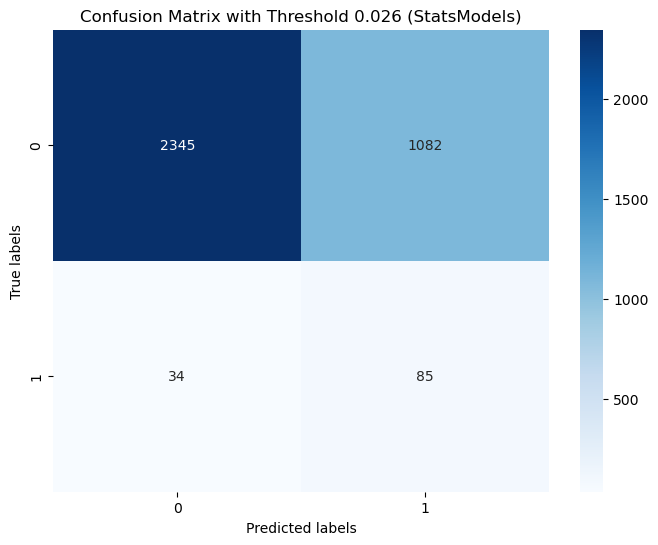

Accuracy: 0.6853
Precision: 0.0728
Recall: 0.7143
F1 Score: 0.1322


In [10]:
# Create a start model: simple logit with all variables, for which threshold is equal to 0,026
model_sm = sm.Logit(y_train_sm, X_train_sm).fit()

X_test_sm = sm.add_constant(X_test)
y_pred_prob_sm = model_sm.predict(X_test_sm)

# Setting 0,026 for threshold 
y_pred_sm = (y_pred_prob_sm >= 0.026).astype(int)


conf_matrix_sm = confusion_matrix(y_test, y_pred_sm)


plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_sm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix with Threshold 0.026 (StatsModels)')
plt.show()
accuracy = accuracy_score(y_test, y_pred_sm)
precision = precision_score(y_test, y_pred_sm)
recall = recall_score(y_test, y_pred_sm)
f1 = f1_score(y_test, y_pred_sm)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")


AUC: 0.7676
Gini Coefficient: 0.5353


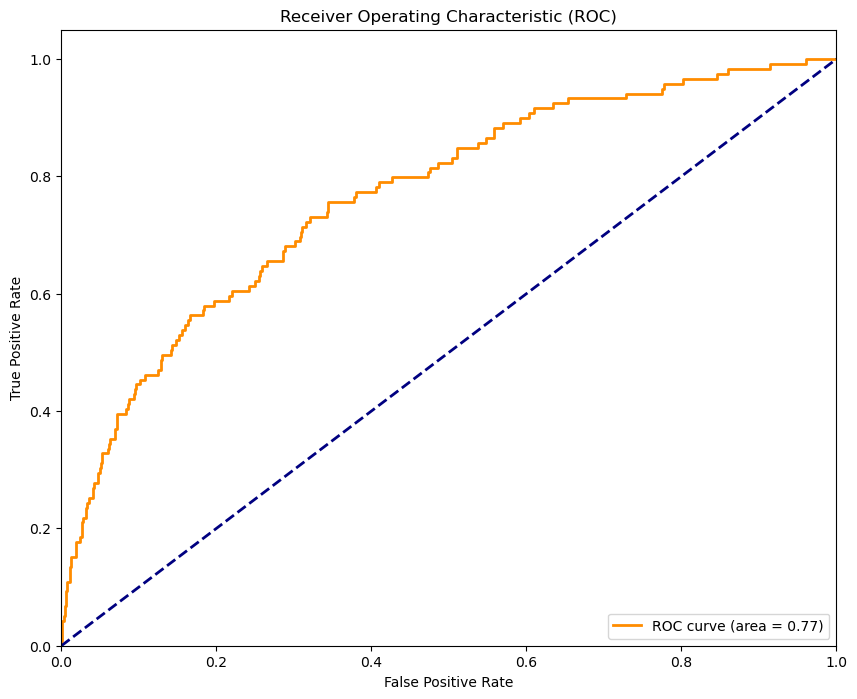

In [32]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

auc = roc_auc_score(y_test, y_pred_prob_sm)
gini = 2 * auc - 1

print(f"AUC: {auc:.4f}")
print(f"Gini Coefficient: {gini:.4f}")

# Generating ROC curve 
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob_sm)

# Drawing ROC curve
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {auc:.2f})')  
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()



# Modifying set of variables to improve predictions using RFE algorithm

In [13]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

# Setting logit model from sklearn to compute RFE
model = LogisticRegression()

# RFE
rfe = RFE(estimator=model, n_features_to_select=1)
rfe = rfe.fit(X_train_sm, y_train_sm)

# Ranking cech
print('Feature rank:', rfe.ranking_)


c:\Users\jansl\.conda\envs\Spyder\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Feature rank: [19  1  6  9  3  7 11 15  2  5 18 17  8 13 10 14  4 12 16]


On the list above we have a rank of the elements in accordance to column index. Below there is a plot which ilustrate this

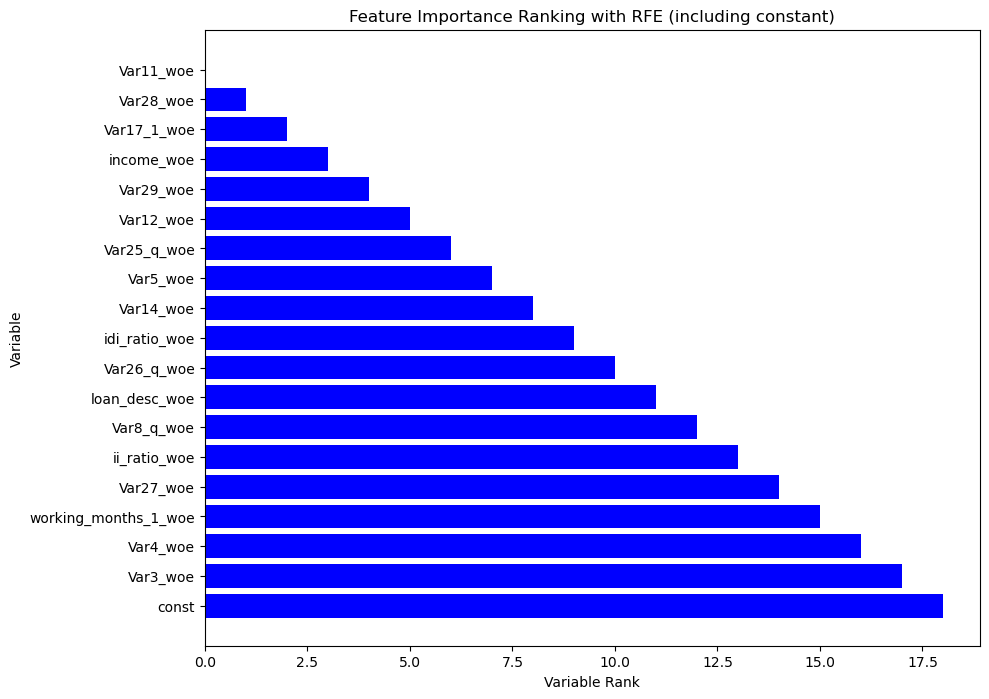

In [27]:
# Preparation of the RFE ranking list
ranking_0_based = rfe.ranking_ - 1

# Sorting indexes according to the ranking
sorted_idx = np.argsort(ranking_0_based)

# Creation of a sorted ranking list
sorted_ranking = ranking_0_based[sorted_idx]

# Assuming we have a list of all feature names, including the constant
feature_names = X_train_sm.columns

# Creation of a list of sorted feature names based on indexes
sorted_feature_names = [feature_names[i] for i in sorted_idx]

# Creating a chart for the feature importance ranking
plt.figure(figsize=(10, 8))
plt.title("Feature Importance Ranking with RFE (including constant)")
plt.barh(range(len(sorted_feature_names)), sorted_ranking, color='blue', align='center')
plt.yticks(range(len(sorted_feature_names)), sorted_feature_names)
plt.xlabel("Variable Rank")
plt.ylabel("Variable")
plt.gca().invert_yaxis()  # Inverting the order so the most important features are at the top

plt.show()


Below there is a algorithm which allows us to elminate variables based on our RFE rank 

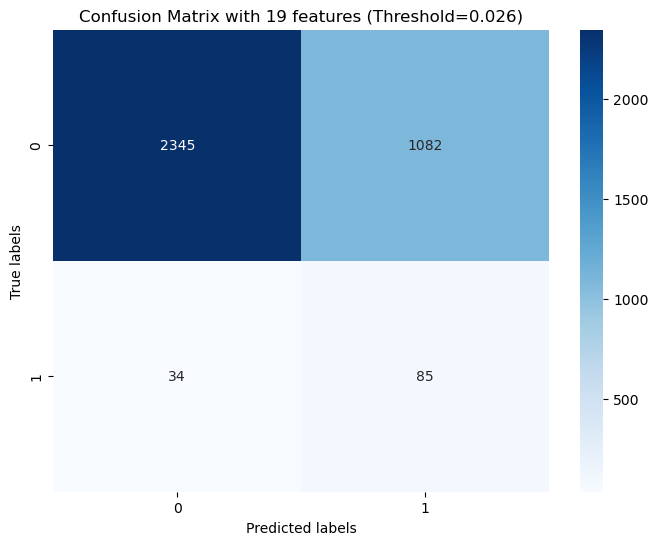

Features removed: []

Features included in the model: ['const', 'Var3_woe', 'Var4_woe', 'working_months_1_woe', 'Var27_woe', 'ii_ratio_woe', 'Var8_q_woe', 'loan_desc_woe', 'Var26_q_woe', 'idi_ratio_woe', 'Var14_woe', 'Var5_woe', 'Var25_q_woe', 'Var12_woe', 'Var29_woe', 'income_woe', 'Var17_1_woe', 'Var28_woe', 'Var11_woe']



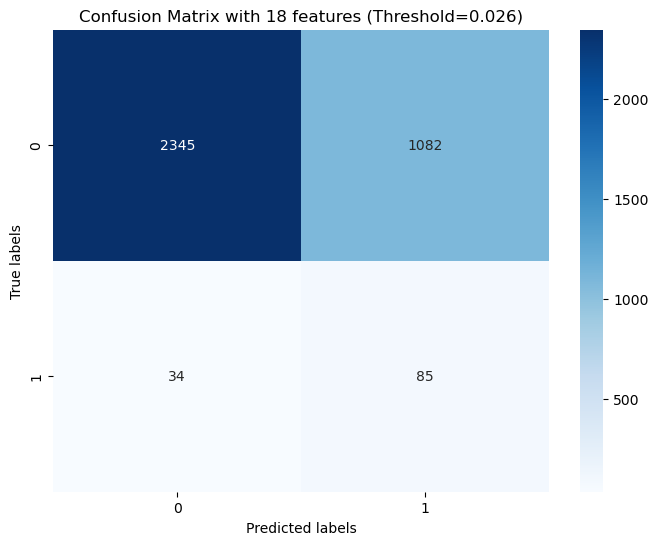

Features removed: ['const']

Features included in the model: ['Var3_woe', 'Var4_woe', 'working_months_1_woe', 'Var27_woe', 'ii_ratio_woe', 'Var8_q_woe', 'loan_desc_woe', 'Var26_q_woe', 'idi_ratio_woe', 'Var14_woe', 'Var5_woe', 'Var25_q_woe', 'Var12_woe', 'Var29_woe', 'income_woe', 'Var17_1_woe', 'Var28_woe', 'Var11_woe']



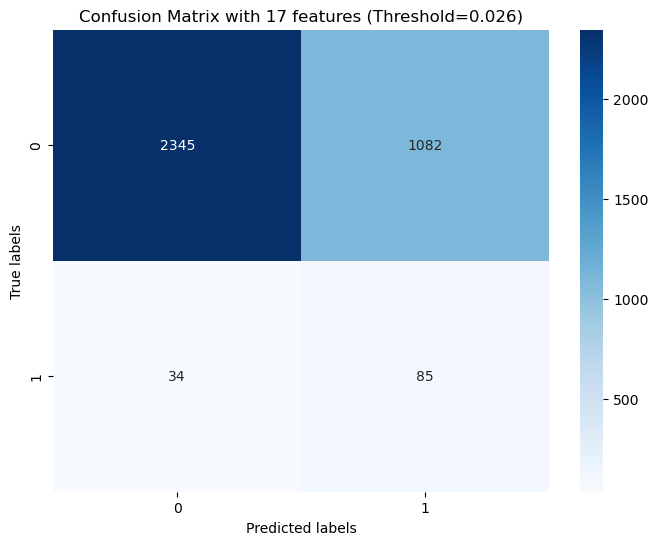

Features removed: ['const', 'Var3_woe']

Features included in the model: ['Var4_woe', 'working_months_1_woe', 'Var27_woe', 'ii_ratio_woe', 'Var8_q_woe', 'loan_desc_woe', 'Var26_q_woe', 'idi_ratio_woe', 'Var14_woe', 'Var5_woe', 'Var25_q_woe', 'Var12_woe', 'Var29_woe', 'income_woe', 'Var17_1_woe', 'Var28_woe', 'Var11_woe']



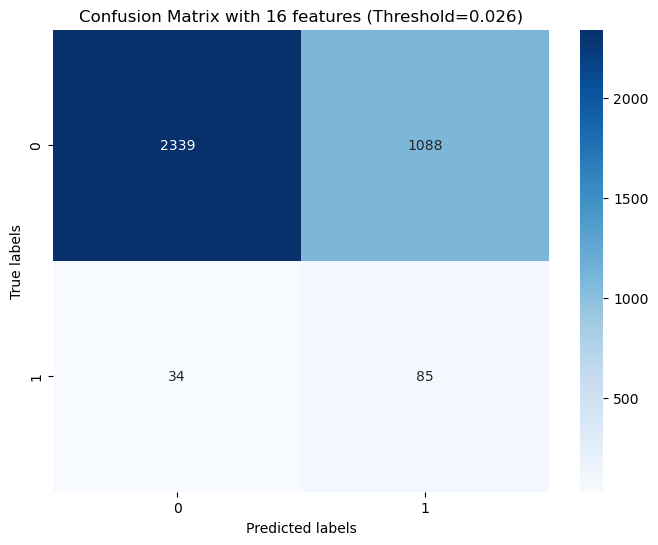

Features removed: ['const', 'Var3_woe', 'Var4_woe']

Features included in the model: ['working_months_1_woe', 'Var27_woe', 'ii_ratio_woe', 'Var8_q_woe', 'loan_desc_woe', 'Var26_q_woe', 'idi_ratio_woe', 'Var14_woe', 'Var5_woe', 'Var25_q_woe', 'Var12_woe', 'Var29_woe', 'income_woe', 'Var17_1_woe', 'Var28_woe', 'Var11_woe']



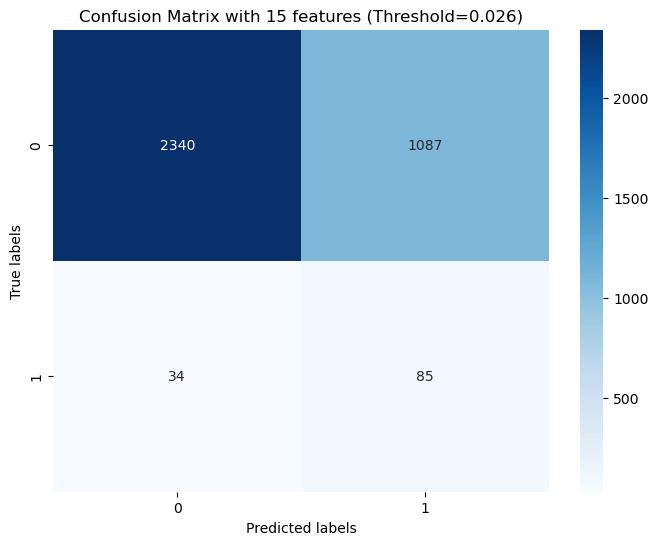

Features removed: ['const', 'Var3_woe', 'Var4_woe', 'working_months_1_woe']

Features included in the model: ['Var27_woe', 'ii_ratio_woe', 'Var8_q_woe', 'loan_desc_woe', 'Var26_q_woe', 'idi_ratio_woe', 'Var14_woe', 'Var5_woe', 'Var25_q_woe', 'Var12_woe', 'Var29_woe', 'income_woe', 'Var17_1_woe', 'Var28_woe', 'Var11_woe']



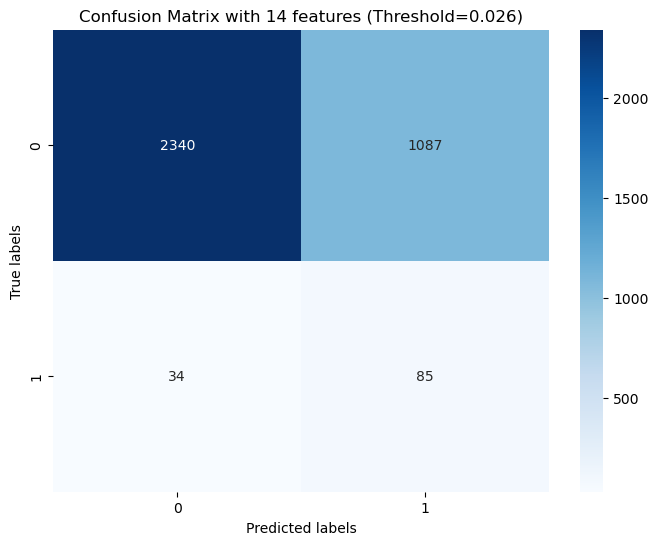

Features removed: ['const', 'Var3_woe', 'Var4_woe', 'working_months_1_woe', 'Var27_woe']

Features included in the model: ['ii_ratio_woe', 'Var8_q_woe', 'loan_desc_woe', 'Var26_q_woe', 'idi_ratio_woe', 'Var14_woe', 'Var5_woe', 'Var25_q_woe', 'Var12_woe', 'Var29_woe', 'income_woe', 'Var17_1_woe', 'Var28_woe', 'Var11_woe']



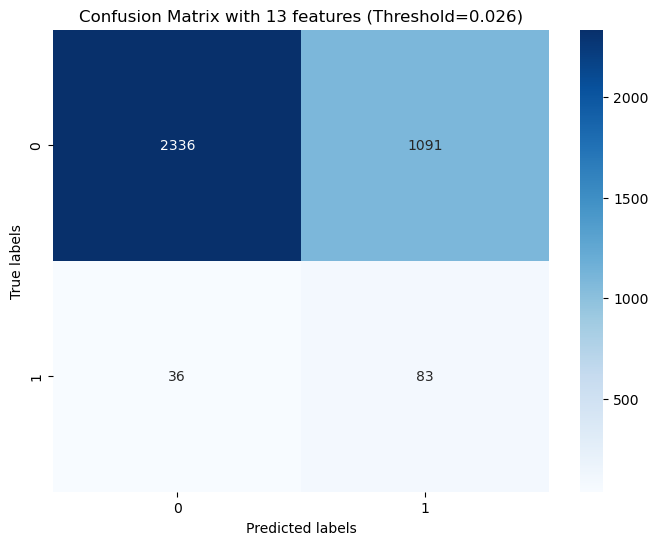

Features removed: ['const', 'Var3_woe', 'Var4_woe', 'working_months_1_woe', 'Var27_woe', 'ii_ratio_woe']

Features included in the model: ['Var8_q_woe', 'loan_desc_woe', 'Var26_q_woe', 'idi_ratio_woe', 'Var14_woe', 'Var5_woe', 'Var25_q_woe', 'Var12_woe', 'Var29_woe', 'income_woe', 'Var17_1_woe', 'Var28_woe', 'Var11_woe']



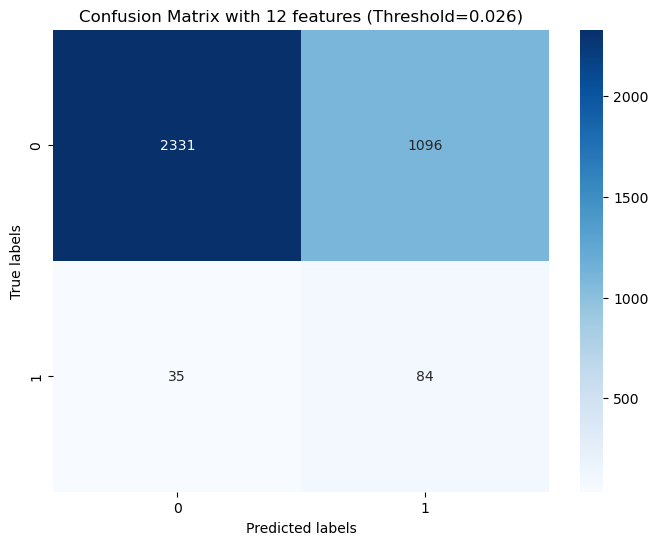

Features removed: ['const', 'Var3_woe', 'Var4_woe', 'working_months_1_woe', 'Var27_woe', 'ii_ratio_woe', 'Var8_q_woe']

Features included in the model: ['loan_desc_woe', 'Var26_q_woe', 'idi_ratio_woe', 'Var14_woe', 'Var5_woe', 'Var25_q_woe', 'Var12_woe', 'Var29_woe', 'income_woe', 'Var17_1_woe', 'Var28_woe', 'Var11_woe']



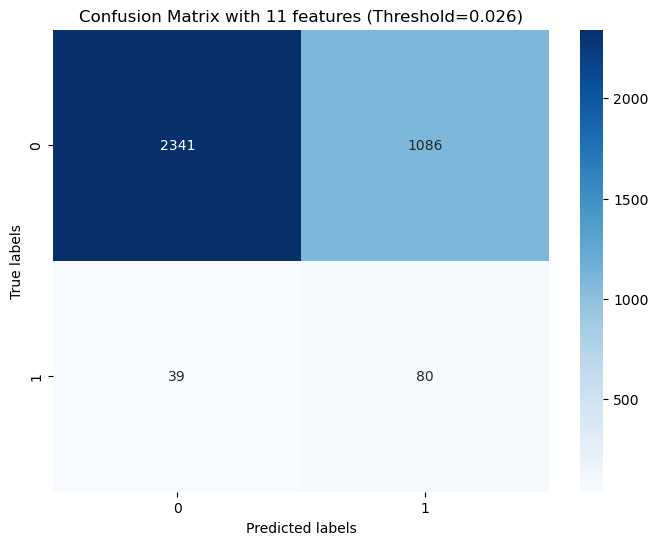

Features removed: ['const', 'Var3_woe', 'Var4_woe', 'working_months_1_woe', 'Var27_woe', 'ii_ratio_woe', 'Var8_q_woe', 'loan_desc_woe']

Features included in the model: ['Var26_q_woe', 'idi_ratio_woe', 'Var14_woe', 'Var5_woe', 'Var25_q_woe', 'Var12_woe', 'Var29_woe', 'income_woe', 'Var17_1_woe', 'Var28_woe', 'Var11_woe']



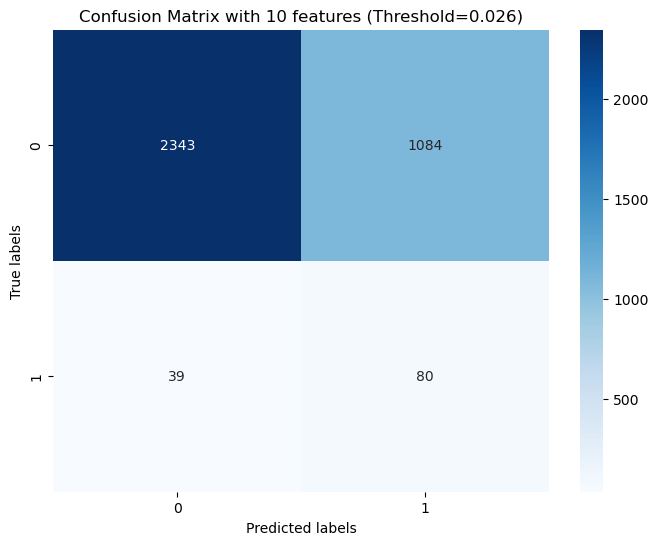

Features removed: ['const', 'Var3_woe', 'Var4_woe', 'working_months_1_woe', 'Var27_woe', 'ii_ratio_woe', 'Var8_q_woe', 'loan_desc_woe', 'Var26_q_woe']

Features included in the model: ['idi_ratio_woe', 'Var14_woe', 'Var5_woe', 'Var25_q_woe', 'Var12_woe', 'Var29_woe', 'income_woe', 'Var17_1_woe', 'Var28_woe', 'Var11_woe']



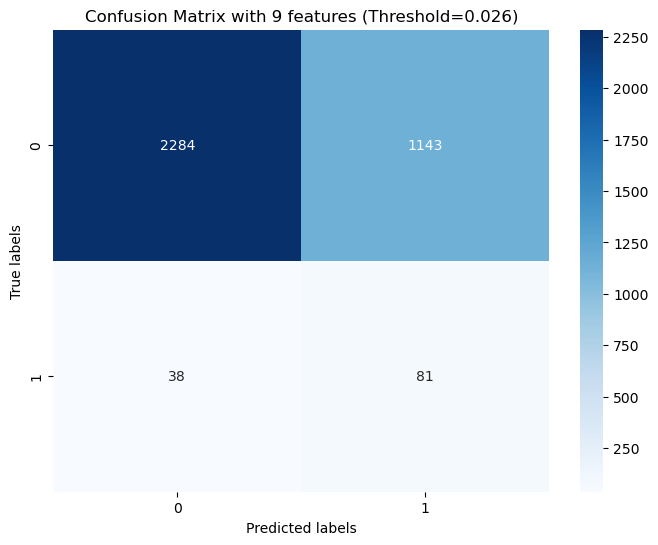

Features removed: ['const', 'Var3_woe', 'Var4_woe', 'working_months_1_woe', 'Var27_woe', 'ii_ratio_woe', 'Var8_q_woe', 'loan_desc_woe', 'Var26_q_woe', 'idi_ratio_woe']

Features included in the model: ['Var14_woe', 'Var5_woe', 'Var25_q_woe', 'Var12_woe', 'Var29_woe', 'income_woe', 'Var17_1_woe', 'Var28_woe', 'Var11_woe']



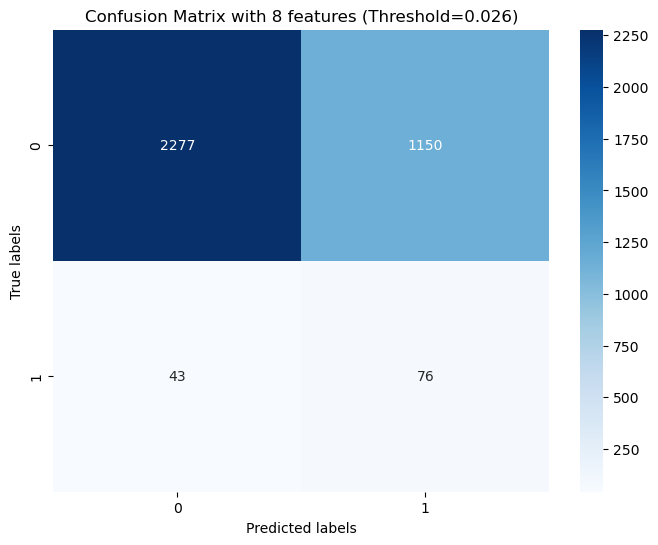

Features removed: ['const', 'Var3_woe', 'Var4_woe', 'working_months_1_woe', 'Var27_woe', 'ii_ratio_woe', 'Var8_q_woe', 'loan_desc_woe', 'Var26_q_woe', 'idi_ratio_woe', 'Var14_woe']

Features included in the model: ['Var5_woe', 'Var25_q_woe', 'Var12_woe', 'Var29_woe', 'income_woe', 'Var17_1_woe', 'Var28_woe', 'Var11_woe']



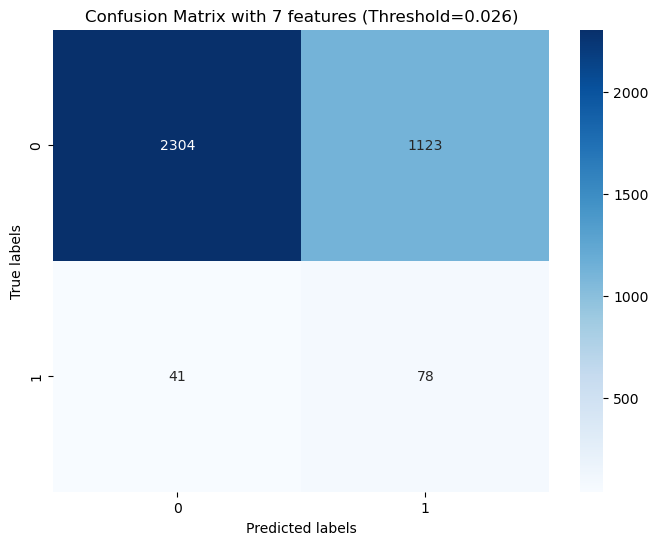

Features removed: ['const', 'Var3_woe', 'Var4_woe', 'working_months_1_woe', 'Var27_woe', 'ii_ratio_woe', 'Var8_q_woe', 'loan_desc_woe', 'Var26_q_woe', 'idi_ratio_woe', 'Var14_woe', 'Var5_woe']

Features included in the model: ['Var25_q_woe', 'Var12_woe', 'Var29_woe', 'income_woe', 'Var17_1_woe', 'Var28_woe', 'Var11_woe']



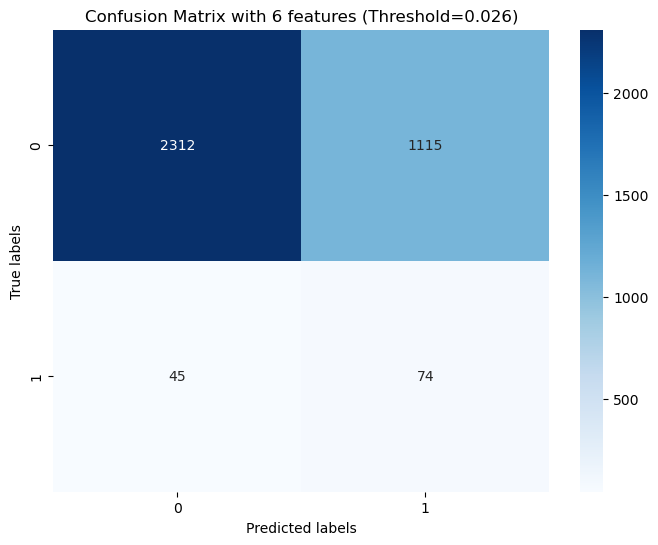

Features removed: ['const', 'Var3_woe', 'Var4_woe', 'working_months_1_woe', 'Var27_woe', 'ii_ratio_woe', 'Var8_q_woe', 'loan_desc_woe', 'Var26_q_woe', 'idi_ratio_woe', 'Var14_woe', 'Var5_woe', 'Var25_q_woe']

Features included in the model: ['Var12_woe', 'Var29_woe', 'income_woe', 'Var17_1_woe', 'Var28_woe', 'Var11_woe']



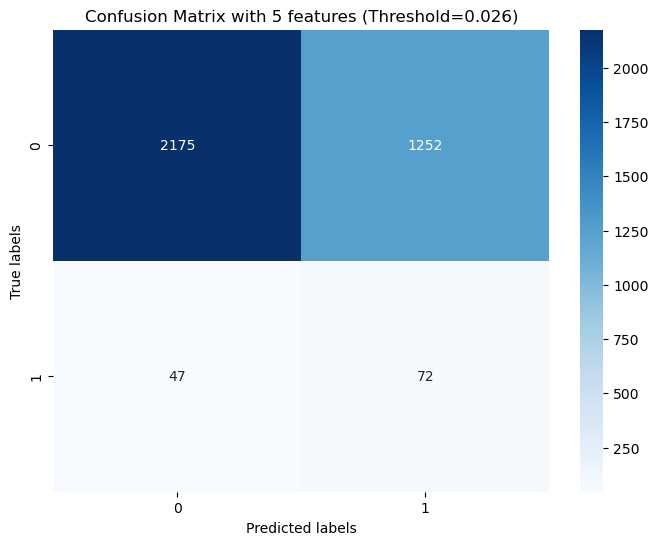

Features removed: ['const', 'Var3_woe', 'Var4_woe', 'working_months_1_woe', 'Var27_woe', 'ii_ratio_woe', 'Var8_q_woe', 'loan_desc_woe', 'Var26_q_woe', 'idi_ratio_woe', 'Var14_woe', 'Var5_woe', 'Var25_q_woe', 'Var12_woe']

Features included in the model: ['Var29_woe', 'income_woe', 'Var17_1_woe', 'Var28_woe', 'Var11_woe']



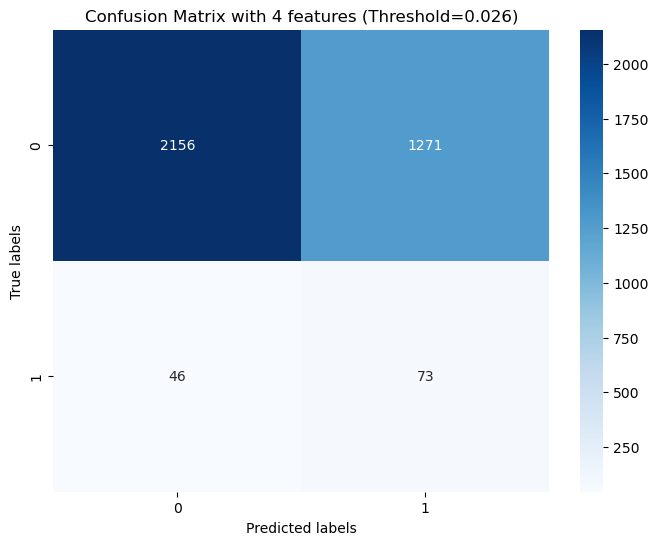

Features removed: ['const', 'Var3_woe', 'Var4_woe', 'working_months_1_woe', 'Var27_woe', 'ii_ratio_woe', 'Var8_q_woe', 'loan_desc_woe', 'Var26_q_woe', 'idi_ratio_woe', 'Var14_woe', 'Var5_woe', 'Var25_q_woe', 'Var12_woe', 'Var29_woe']

Features included in the model: ['income_woe', 'Var17_1_woe', 'Var28_woe', 'Var11_woe']



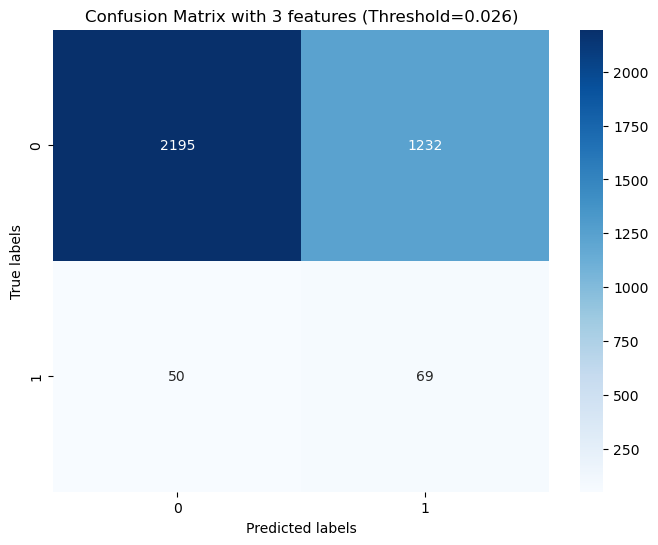

Features removed: ['const', 'Var3_woe', 'Var4_woe', 'working_months_1_woe', 'Var27_woe', 'ii_ratio_woe', 'Var8_q_woe', 'loan_desc_woe', 'Var26_q_woe', 'idi_ratio_woe', 'Var14_woe', 'Var5_woe', 'Var25_q_woe', 'Var12_woe', 'Var29_woe', 'income_woe']

Features included in the model: ['Var17_1_woe', 'Var28_woe', 'Var11_woe']



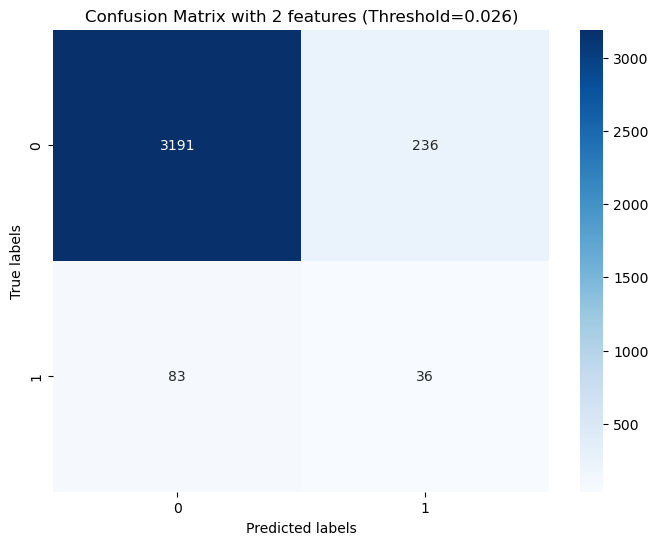

Features removed: ['const', 'Var3_woe', 'Var4_woe', 'working_months_1_woe', 'Var27_woe', 'ii_ratio_woe', 'Var8_q_woe', 'loan_desc_woe', 'Var26_q_woe', 'idi_ratio_woe', 'Var14_woe', 'Var5_woe', 'Var25_q_woe', 'Var12_woe', 'Var29_woe', 'income_woe', 'Var17_1_woe']

Features included in the model: ['Var28_woe', 'Var11_woe']



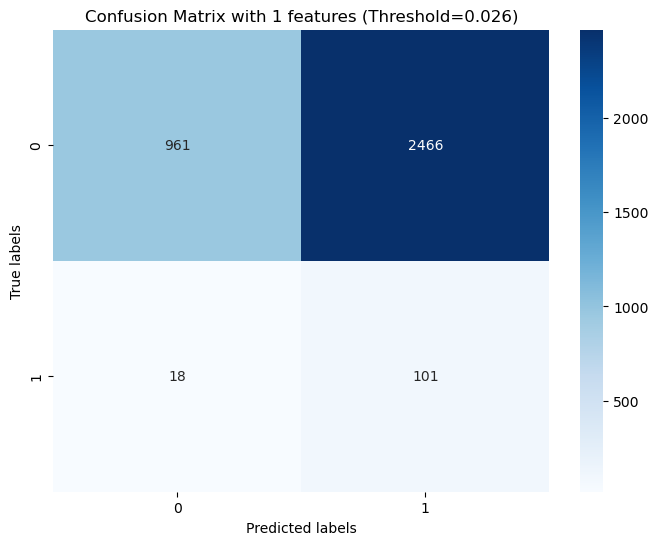

Features removed: ['const', 'Var3_woe', 'Var4_woe', 'working_months_1_woe', 'Var27_woe', 'ii_ratio_woe', 'Var8_q_woe', 'loan_desc_woe', 'Var26_q_woe', 'idi_ratio_woe', 'Var14_woe', 'Var5_woe', 'Var25_q_woe', 'Var12_woe', 'Var29_woe', 'income_woe', 'Var17_1_woe', 'Var28_woe']

Features included in the model: ['Var11_woe']



In [28]:
import statsmodels.api as sm
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


threshold = 0.026

# Prepering names of columns to sorting
feature_names = X_train_sm.columns.tolist()

# RFE rank 
ranking_rfe = ranking_0_based

# Sorting features according to RFE ranking
#  First, we create a pair (feature_name, ranking) for each feature
features_with_ranking = zip(feature_names, ranking_rfe)

# Next we are sorting by rank key, from highest to lowest 
sorted_features = sorted(features_with_ranking, key=lambda x: x[1], reverse=True)

#Take sorted names for features
sorted_feature_names = [feature for feature, rank in sorted_features]

# Iterational exluding of variables and model training
for i in range(len(sorted_feature_names), 0, -1):
    
    selected_features = sorted_feature_names[-i:]
    
   
    X_train_selected = X_train_sm[selected_features]
    X_test_selected = X_test_sm[selected_features]
    
   
    X_train_selected_with_const = sm.add_constant(X_train_selected)
    X_test_selected_with_const = sm.add_constant(X_test_selected)
    
    
    model = sm.Logit(y_train_sm, X_train_selected_with_const).fit(disp=0)
    
    y_pred_prob = model.predict(X_test_selected_with_const)
    y_pred = (y_pred_prob >= threshold).astype(int)
    
    
    conf_matrix = confusion_matrix(y_test, y_pred)
    
   
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues')
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title(f'Confusion Matrix with {len(selected_features)} features (Threshold={threshold})')
    plt.show()
    
    
    print(f"Features removed: {sorted_feature_names[:len(sorted_feature_names)-i]}\n")
    print(f"Features included in the model: {selected_features}\n")


Due to difficulties with choosing the best model, we should use the proper algorithm. The code with implementation is posted below

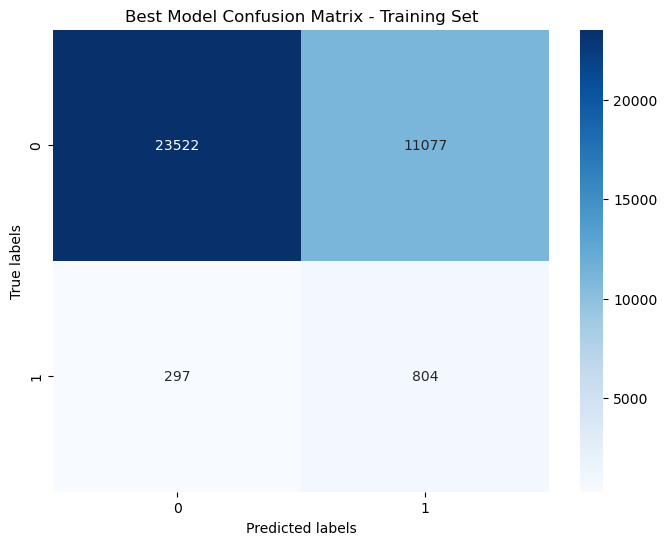

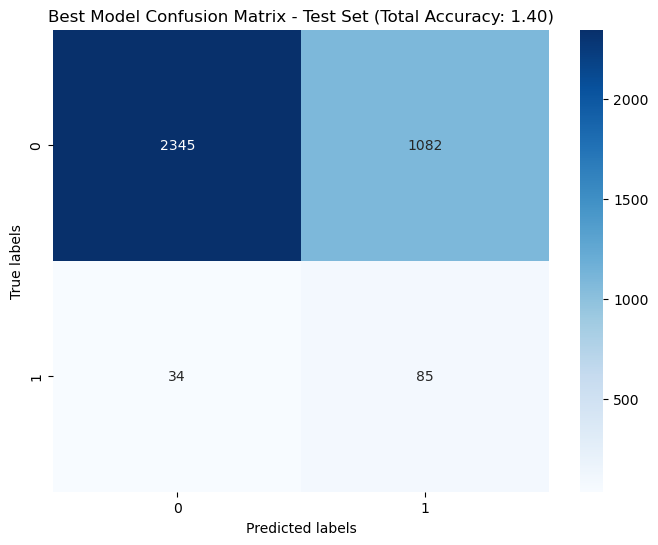

Best model uses 19 features: ['const', 'Var3_woe', 'Var4_woe', 'working_months_1_woe', 'Var27_woe', 'ii_ratio_woe', 'Var8_q_woe', 'loan_desc_woe', 'Var26_q_woe', 'idi_ratio_woe', 'Var14_woe', 'Var5_woe', 'Var25_q_woe', 'Var12_woe', 'Var29_woe', 'income_woe', 'Var17_1_woe', 'Var28_woe', 'Var11_woe']
Features removed: set()



In [41]:
import statsmodels.api as sm
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Assuming X_train_sm, y_train_sm, X_test_sm, y_test are defined and contain the training and test data

# Setting the threshold for classification
threshold = 0.026

# Preparing the list of feature names (Assuming this is defined somewhere above)
feature_names = X_train_sm.columns.tolist()

# Sample RFE ranking (Assuming this is defined somewhere above)
ranking_rfe = [18, 0, 5, 8, 2, 6, 10, 14, 1, 4, 17, 16, 7, 12, 9, 13, 3, 11, 15]

# Sorting features according to RFE ranking
sorted_features = [feature for feature, rank in sorted(zip(feature_names, ranking_rfe), key=lambda x: x[1], reverse=True)]

best_score = 0
best_model_info = {}

for i in range(len(sorted_features), 0, -1):
    # Selecting features to include in the model
    selected_features = sorted_features[-i:]
    
    # Preparing data with selected features for training
    X_train_selected = X_train_sm[selected_features]
    
    # Adding a constant to the model after selecting features for training
    X_train_selected_with_const = sm.add_constant(X_train_selected)
    
    # Training the model
    model = sm.Logit(y_train_sm, X_train_selected_with_const).fit(disp=0)
    
    # Prediction on training data to evaluate confusion matrix on the training set
    y_pred_train_prob = model.predict(X_train_selected_with_const)
    y_pred_train = (y_pred_train_prob >= threshold).astype(int)
    
    # Calculating the confusion matrix for the training set
    conf_matrix_train = confusion_matrix(y_train_sm, y_pred_train)

    # Prediction on test data to calculate confusion matrix and accuracy
    X_test_selected = X_test_sm[selected_features]
    X_test_selected_with_const = sm.add_constant(X_test_selected)
    y_pred_prob = model.predict(X_test_selected_with_const)
    y_pred = (y_pred_prob >= threshold).astype(int)
    conf_matrix_test = confusion_matrix(y_test, y_pred)
    
    # Calculating accuracy for both classes and their sum for the test set
    accuracy_0 = conf_matrix_test[0, 0] / np.sum(conf_matrix_test[0])
    accuracy_1 = conf_matrix_test[1, 1] / np.sum(conf_matrix_test[1])
    total_accuracy = accuracy_0 + accuracy_1
    
    # Updating the best model if the current accuracy is better
    if total_accuracy > best_score:
        best_score = total_accuracy
        best_model_info = {
            'model': model,
            'selected_features': selected_features,
            'conf_matrix_train': conf_matrix_train,  # Storing training set confusion matrix
            'conf_matrix_test': conf_matrix_test,  # Storing test set confusion matrix
            'total_accuracy': total_accuracy
        }

# Displaying the best model's confusion matrix for the training set
plt.figure(figsize=(8, 6))
sns.heatmap(best_model_info['conf_matrix_train'], annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Best Model Confusion Matrix - Training Set')
plt.show()

# Displaying the best model's confusion matrix for the test set
plt.figure(figsize=(8, 6))
sns.heatmap(best_model_info['conf_matrix_test'], annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title(f'Best Model Confusion Matrix - Test Set (Total Accuracy: {best_model_info["total_accuracy"]:.2f})')
plt.show()

# Additional information about the best model
print(f"Best model uses {len(best_model_info['selected_features'])} features: {best_model_info['selected_features']}")
print(f"Features removed: {set(feature_names) - set(best_model_info['selected_features'])}\n")


Below there is the best logit model optimized by the highest possible sum of these outputs (TRUE POSITIVE + TRUE NEGATIVE)

                           Logit Regression Results                           
Dep. Variable:                 target   No. Observations:                35700
Model:                          Logit   Df Residuals:                    35681
Method:                           MLE   Df Model:                           18
Date:                Thu, 14 Mar 2024   Pseudo R-squ.:                  0.1560
Time:                        22:10:26   Log-Likelihood:                -4147.4
converged:                       True   LL-Null:                       -4914.1
Covariance Type:            nonrobust   LLR p-value:                     0.000
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   12.6964      0.565     22.458      0.000      11.588      13.804
Var3_woe                 0.0354      0.275      0.129      0.898      -0.504       0.575
Var4_woe    

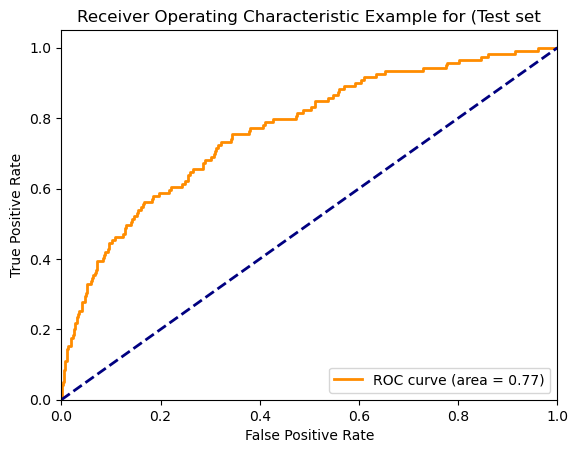

In [39]:
from sklearn.metrics import roc_curve, auc
import numpy as np

# Displaying the summary of the best model
print(best_model_info['model'].summary())

# Calculating values for the AUC-ROC curve
y_pred_prob = best_model_info['model'].predict(sm.add_constant(X_test_sm[best_model_info['selected_features']]))
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Plotting the AUC-ROC curve
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Example for (Test set')
plt.legend(loc="lower right")
plt.show()


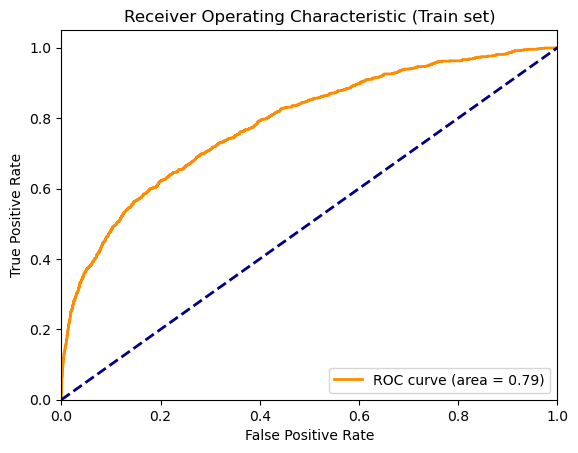

In [36]:
# For trianing set 
y_pred_prob_train = best_model_info['model'].predict(sm.add_constant(X_train_sm[best_model_info['selected_features']]))

fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_pred_prob_train)
roc_auc_train = auc(fpr_train, tpr_train)

plt.figure()
lw = 2
plt.plot(fpr_train, tpr_train, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc_train)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (Train set)')
plt.legend(loc="lower right")
plt.show()

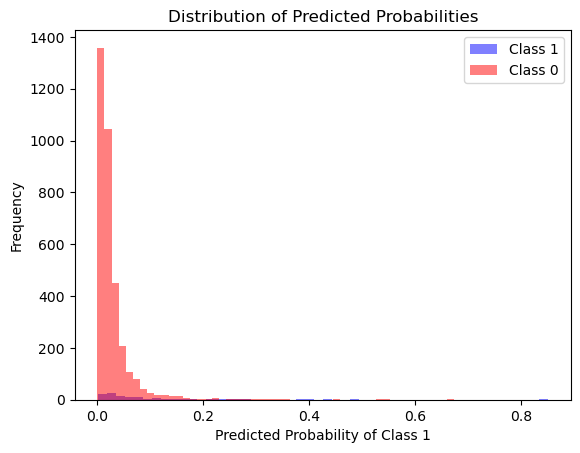

In [31]:
import matplotlib.pyplot as plt
import numpy as np

plt.hist(y_pred_prob[y_test == 1], bins=50, color='blue', alpha=0.5, label='Class 1')
plt.hist(y_pred_prob[y_test == 0], bins=50, color='red', alpha=0.5, label='Class 0')

plt.xlabel('Predicted Probability of Class 1')
plt.ylabel('Frequency')
plt.title('Distribution of Predicted Probabilities')
plt.legend()
plt.show()





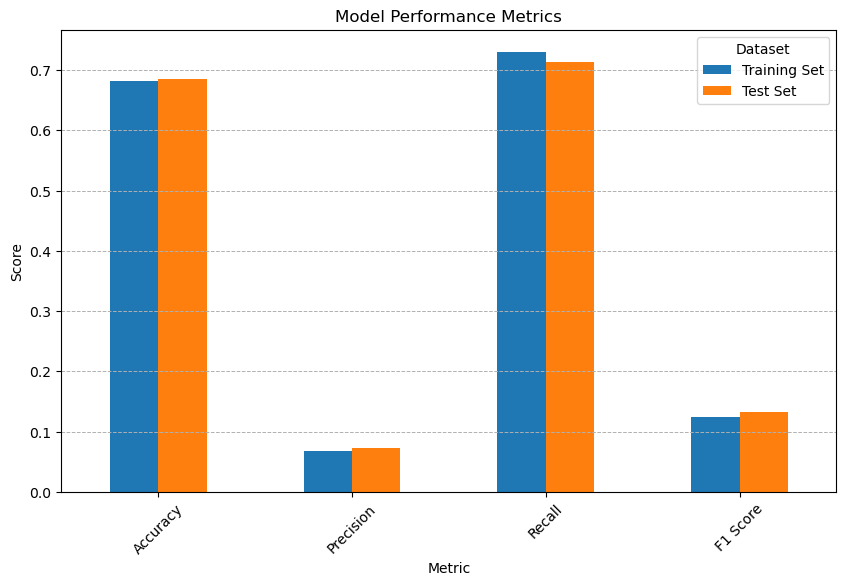

In [42]:
# Preparing predictions for training set
y_pred_train_prob = best_model_info['model'].predict(sm.add_constant(X_train_sm[best_model_info['selected_features']]))
y_pred_train = (y_pred_train_prob >= threshold).astype(int)

# Preparing predictions for test set
y_pred_test_prob = best_model_info['model'].predict(sm.add_constant(X_test_sm[best_model_info['selected_features']]))
y_pred_test = (y_pred_test_prob >= threshold).astype(int)

# Calculating metrics for the training set
accuracy_train = accuracy_score(y_train_sm, y_pred_train)
precision_train = precision_score(y_train_sm, y_pred_train)
recall_train = recall_score(y_train_sm, y_pred_train)
f1_train = f1_score(y_train_sm, y_pred_train)

# Calculating metrics for the test set
accuracy_test = accuracy_score(y_test, y_pred_test)
precision_test = precision_score(y_test, y_pred_test)
recall_test = recall_score(y_test, y_pred_test)
f1_test = f1_score(y_test, y_pred_test)


# Creating a DataFrame to hold the metrics for both sets
metrics_df = pd.DataFrame(
    {
        "Metric": ["Accuracy", "Precision", "Recall", "F1 Score"],
        "Training Set": [accuracy_train, precision_train, recall_train, f1_train],
        "Test Set": [accuracy_test, precision_test, recall_test, f1_test]
    }
)

# Plotting the metrics
fig, ax = plt.subplots(figsize=(10, 6))
metrics_df.plot(kind='bar', x='Metric', y=["Training Set", "Test Set"], ax=ax)
plt.title('Model Performance Metrics')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.legend(title="Dataset")
plt.grid(axis='y', linestyle='--', linewidth=0.7)
plt.show()